# Registering Distorted LIDAR Scans to HD Map Provided in Newer College Dataset

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-07-19 15:26:10.785774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 15:26:10.933894: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 15:26:11.511591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-19 15:26:11.511667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-19 15:26:12.496416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 15:26:12.497524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 15:26:12.497868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 15:26:12.498121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#Load HD Map from .ply File
import trimesh

# pl = '/home/derm/Downloads/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply' #provided in Google Drive 03
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
# print(type(HD_map))

# Draw HD Map

In [3]:
#Test drawing downsampled version of HD Map (laptop alert)
show_nth = 10 #was this -- having trouble not forming voxels on surfaces very close to sensor
# show_nth = 3 #test using more points from HD Map
submap = HD_map[::show_nth]
# submap[:,2] += min(submap[:,2])
print(np.shape(submap))

# submap = submap[submap[:,2]> -0.9]#remove ground plane (for scan to submap in experiment 1)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
# draw in red
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  

## rainbow by z height
# # zheight = 50*(np.sin(0.0625*submap[:,2])+1)#was this
# zheight = 100*(np.sin(0.25*submap[:,2])+1) #test
# print(zheight[::100], min(zheight), max(zheight))
# # cname = np.array([zheight, 100*(np.sin(0.5*zheight+256)+1), 128*np.ones(len(zheight))]).T.tolist()
# cname = np.array([zheight, zheight, zheight]).T.tolist()
# # cname = np.array([64*np.ones(len(zheight)), 256 - zheight/2, 256 - zheight]).T.tolist()
# disp.append(Points(submap, c = cname, r = 2, alpha = 0.1))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

# Register scan using rigid ICET

In [4]:
# idx = 400
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
# # fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"

# pc1 = np.load(fn1)

# #load ground truth
# # [sec,nsec,x,y,z,qx,qy,qz,qw]
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# # fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
# gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# # print(gt[idx, 2:])

# offset = 0#for debug 
# rot = R.from_quat(gt[idx+offset,5:]).as_euler('xyz')
# # rot_m = R.from_quat(gt[idx+offset,5:]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# rot_m = R.from_euler('xyz', [0, 0, rot[2]]).as_matrix()
# # rot_m = R.from_euler('xyz', [rot[0], rot[1], -rot[2] - np.pi/8 ]).as_matrix()
# # rot_m = R.from_quat(gt[idx,5:]).inv().as_matrix()
# # print(rot_m)

# initial_guess = tf.cast(tf.constant([gt[idx+offset,2], gt[idx+offset,3], gt[idx+offset,4], rot[0], rot[1], rot[2] ]), tf.float32)
# # pc1 = pc1 @ rot_m
# # rotcorr = R.from_euler('xyz', [0,0,np.pi/8]).as_matrix() #need to correct 45 degree offset??
# # pc1 = pc1 @ rotcorr
# # pc1 += initial_guess[:3]

# Get Ground Truth Poses with code from KitWare pyLiDAR-SLAM library

In [5]:
#load ground truth .csv file
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
# T_CL[:3, 3] = np.array([0.084, 0.025, -0.050], dtype=np.float32) #debugging possible sign errors
poses = np.einsum("nij,jk->nik", poses, T_CL)

initial_pose = np.linalg.inv(poses[0]) 

poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

<IPython.core.display.Javascript object>


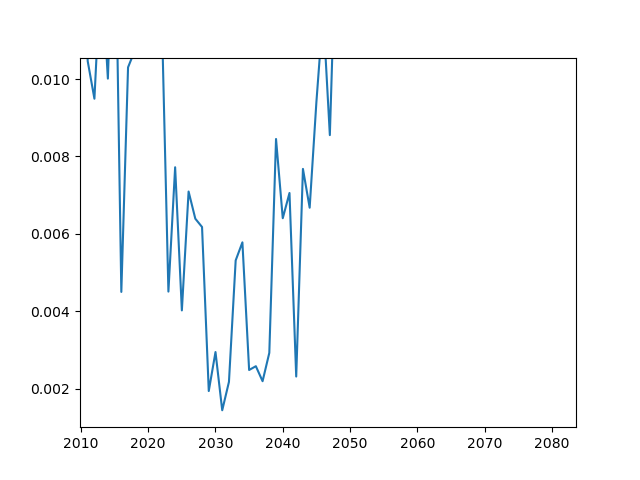

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

# ax.plot(poses[:,:3,3])
# ax.plot(np.diff(poses[:,:3,3], axis = 0))
# poses_euls = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# ax.plot(poses_euls[:,:])

fwd_vel = np.sqrt(np.diff(poses[:,0,3])**2 + np.diff(poses[:,1,3])**2)
ax.plot(fwd_vel)

## Regsiter Raw Clouds i, j, and HD Map centered on origin of i 

In [10]:
idx = 0 #2700 #2650 #2000 - 3000 is the running and swinging loop
# idx = 2400 #very obvious translation distortion
# idx = 2800 #VICET does much better than rigid ICET here!
# idx = 2020 #static start
skip = 20 #10 #how many lidar frames between clouds
# (need to deal with how there are more LIDAR frames than ground truth poses)
offset = 10 #10 #11  #works best for 05 dataset
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + offset) + ".npy"
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

# idx = 950 #1080 #950 #fast motion
# # idx = 990 #slow distortion, very accurate solution
# # idx = 530 #pan only -- HD map transformation doesn't work for this part of the dataset but 
# # idx = 280 #from staic(ish) start
# # idx = 990 #test for visualization (316 looks really good)
# skip = 1 #30 #how many lidar frames between clouds
# offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
# fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + offset) + ".npy"
# fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + skip + offset) + ".npy"

pc1 = np.load(fn1)
pc2 = np.load(fn2)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#apply homogeneous transform matrix
scan1_mapframe = (poses[idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
scan2_mapframe = (poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

#alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# disp.append(Points(pc1, c = '#a65852', r = 3)) #red
pc2_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ poses[idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
# disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]
disp.append(Points(submap_in_pc1_frame, c = "black", r = 2, alpha = 0.1)) ##CB2314
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# #Rotate scans to align beginning of each scan with +X axis ----------
# #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
# #           this is becuase overall trajectory begins at 05 (at least I think that's why)
# #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
# scan1_mapframe = (np.linalg.pinv(poses[idx]) @ scan1_mapframe.T).T 
# scan2_mapframe = (np.linalg.pinv(poses[idx]) @ scan2_mapframe.T).T
# submap_mapframe = (np.linalg.pinv(poses[idx]) @ submap_mapframe.T).T
# #--------------------------------------------------------------------

#remove 4th column and center first scan about origin
scan1_lidarframe = scan1_mapframe[:,:3] - poses[idx][:3,3]
scan2_lidarframe = scan2_mapframe[:,:3] - poses[idx][:3,3]
submap_lidarframe = submap_mapframe[:,:3] - poses[idx][:3,3]

# #COLOR SCAN1 POINTS BY ORDER IN CLOUD ~~~~~~~~~~~~~~~~~~~~~~~~~~~
# color = 255*np.linspace(0,1,len(scan1_lidarframe))
# cname = np.array([255-color//2, color, 255-color]).T.tolist()
# # disp.append(Points(scan1_lidarframe, c = cname, r = 3, alpha = 1))
# disp.append(Points(pc1, c = cname, r = 3, alpha = 1))
# # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
disp.append(Points(pc2_in_pc1_frame, c = '#2c7c94', r = 3)) #blue

# disp.append(Points(OG_in_hull, c = '#a65852', r = 5)) #red
# disp.append(Points(trans_in_hull, c = '#2c7c94', r = 5)) #blue
# disp.append(Points(pc1[::100,:], c = '#a65852', r = 3)) #red

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Run VICET (12-State ICET)

In [73]:
from linear_corrector import LC
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])

max_buffer = 2.5 #0.5 #was 2.5

# #add initial offset for LIDAR scan
# trans = np.array([0.5, 0.0, 0.1])
# scan1_lidarframe += trans

#scan to submap
# dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 25, 
#         draw = True, mnp = 25, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 35, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)

dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
        fid = 50, niter = 100, draw = True, mnp = 50, 
        RM = False, solver = '12_state', 
        max_buffer = max_buffer, A0 = A0)

# # # # scan to scan
# dc = LC(cloud1 = pc1, cloud2 = pc2_in_pc1_frame, fid = 50, niter = 25, 
#         draw = True, mnp = 50, RM = False, solver = '12_state', 
#         max_buffer = max_buffer, A0 = A0)
# # dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
# #         fid = 50, niter = 50, draw = True, mnp = 50, 
# #         RM = False, solver = '12_state', 
# #         max_buffer = max_buffer, A0 = A0)

ViewInteractiveWidget(dc.plt.window)

A0:
 [-0.02558972 -0.17548399  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0257 -0.1761  0.0109  0.0027 -0.0009 -0.002 ] 
 [-0.0167 -0.0002 -0.0075  0.0004  0.0031  0.0032]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1586: RuntimeWarning: divide by zero encountered in double_scalars
  #get total overlap in rotation between LIDAR and base frames (since both are rotating w.r.t. world Z)


A: 
 [-0.0264 -0.1768  0.019   0.0048 -0.002  -0.0035] 
 [-0.0283 -0.0005 -0.0115  0.0014  0.006   0.0056]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0281 -0.1769  0.0251  0.0063 -0.0031 -0.0047] 
 [-0.037  -0.0006 -0.0135  0.0027  0.0088  0.0078]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0305 -0.1766  0.0289  0.0073 -0.0042 -0.0059] 
 [-0.0446 -0.0005 -0.0123  0.0045  0.0113  0.0098]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0337 -0.176   0.0309  0.008  -0.0053 -0.007 ] 
 [-0.0494 -0.0002 -0.0086  0.0065  0.0135  0.0116]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0369 -0.1751  0.0317  0.0084 -0.0063 -0.0078] 
 [-0.0526  0.0003 -0.0032  0.0086  0.0155  0.0132]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0398 -0.1733  0.0331  0.009  -0.0073 -0.0086] 
 [-0.0563  0.0012  0.0007  0.0103  0.0172  0.0149]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0425 -0.1715  0.0334  0.0092 -0.0082 -0.0093] 
 [-0.0589  0.0021  0.0063  0.0122  0.0188  0.0163]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.0406 -0.1402 -0.0421  0.0007 -0.0234 -0.0111] 
 [-0.0662  0.0195  0.2658  0.059   0.0405  0.0166]
~~~~~~~~~~~Iteration  60 ~~~~~~~~~~
A: 
 [-0.0404 -0.1398 -0.0431  0.0007 -0.0234 -0.0111] 
 [-0.0658  0.0198  0.2681  0.0592  0.0405  0.0165]
~~~~~~~~~~~Iteration  61 ~~~~~~~~~~
A: 
 [-0.0403 -0.1394 -0.0441  0.0006 -0.0234 -0.011 ] 
 [-0.0654  0.02    0.2704  0.0595  0.0405  0.0164]
~~~~~~~~~~~Iteration  62 ~~~~~~~~~~
A: 
 [-0.0402 -0.139  -0.0451  0.0006 -0.0235 -0.011 ] 
 [-0.065   0.0202  0.2728  0.0597  0.0405  0.0163]
~~~~~~~~~~~Iteration  63 ~~~~~~~~~~
A: 
 [-0.04   -0.1386 -0.046   0.0005 -0.0235 -0.011 ] 
 [-0.0646  0.0205  0.2751  0.06    0.0405  0.0162]
~~~~~~~~~~~Iteration  64 ~~~~~~~~~~
A: 
 [-0.0398 -0.1381 -0.0468  0.0005 -0.0235 -0.011 ] 
 [-0.0643  0.0208  0.2768  0.0601  0.0405  0.016 ]
~~~~~~~~~~~Iteration  65 ~~~~~~~~~~
A: 
 [-0.0396 -0.1377 -0.0477  0.0005 -0.0235 -0.0109] 
 [-0.0639  0.021   0.2785  0.0603  0.0404  0.0159]
~~~~~~~~~~~Iteration  66 ~~~~~~~~~~

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [64]:
initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
       draw = True, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
ViewInteractiveWidget(it.plt.window)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.00123925  0.18927673 -0.00011616  0.02996681  0.00272247 -0.00301144], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

In [71]:
print("\n VICET predicted standard deviations of error: \n", dc.pred_stds[:6].numpy())
print("\n ICET predicted standard deviations of error: \n",  it.pred_stds.numpy())


 VICET predicted standard deviations of error: 
 [0.00108066 0.00071908 0.00037293 0.00009844 0.00015674 0.00016103]

 ICET predicted standard deviations of error: 
 [0.00044402 0.00184056 0.00045728 0.00006234 0.0000442  0.00005519]


In [45]:
#test ICP registration on a single pair of frames
# icp_rigid_transform, _, _ = trimesh.registration.icp(pc1, pc2_in_pc1_frame) #scan to scan
icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
icp_trans = icp_rigid_transform[:3,3]
icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
print(icp_trans, icp_euls)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

alph = 0.4
disp.append(Points(pc1, c = 'red', r =3, alpha = alph))
disp.append(Points(transformed_pc1, c = 'blue', r =3, alpha = alph))
disp.append(Points(submap_in_pc1_frame, c = 'grey', r = 3, alpha = alph))

plt.show(disp, "ICP Test")
ViewInteractiveWidget(plt.window)

[-0.25157137  0.0971057  -0.52209169] [ 0.00794625  0.01876723 -0.00678358]


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## TODO: remove points from scan1 that lie far outside convex hull of HD Map (so we can calculate proper chamfer distance

In [29]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# tested = np.random.rand(1000,3)
# cloud  = np.random.rand(50,3)
# print(in_hull(tested,cloud))

# hull_inflation_scale = 1.05 #tight bounds around HD Map-- good for Quad With Dynamics
hull_inflation_scale = 1.125 #-- need wider bounds for Dynamic Spinning Trajectory 
hull = hull_inflation_scale*submap_in_pc1_frame[::100] #downsample and stretch
pc1_in_hull = pc1[np.where( in_hull(pc1, hull) )]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1, c ='red', r = 3))
disp.append(Points(pc1_in_hull, c = 'blue', r = 3))
# disp.append(Points(hull, c = 'k', alpha = 0.2))
disp.append(Points(submap_in_pc1_frame, c = 'k', r = 1, alpha = 0.2))
plt.show(disp, "Point Cloud 1 inside Convex Hull, Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Calculate chamfer distance before and after rectification on single frame

#### From the GitHub README:
Here, dist is the Chamfer distance between source_cloud and target_cloud. Note that Chamfer distance is not bidirectional (and, in stricter parlance, it is not a distance metric).
https://github.com/krrish94/chamferdist/tree/master

In [31]:
import torch
from chamferdist import ChamferDistance

chamferDist = ChamferDistance()

subsample = 10 #downsample to every nth point

# #consider all LIDAR points (outliers cause chamfer distance to be not super useful)
# source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy()[::subsample,:])[None,:,:] #OG scan
# source_cloud_trans = torch.from_numpy(dc.cloud2_tensor.numpy()[::subsample,:])[None,:,:] #transformed scan

#only consdier LIDAR points within convex hull of HD Map + some buffer
hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:] #subsample
OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()

trans_in_hull = dc.cloud2_tensor.numpy()[::subsample,:] #subsample
trans_in_hull = trans_in_hull[np.where( in_hull(trans_in_hull, hull) )]
source_cloud_trans = torch.from_numpy(trans_in_hull)[None,:,:].float() 

target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]

# #downsample LIDAR clouds -- not sure why this doesn't work
# subsample_size = 10_000
# full_OG = dc.cloud2_tensor_OG.numpy()
# new_OG = full_OG[np.random.choice(full_OG.shape[0], subsample_size, replace=False), :]
# source_cloud_OG = torch.from_numpy(new_OG)[None,:,:] #OG scan
# full_trans = dc.cloud2_tensor.numpy()
# new_trans = full_trans[np.random.choice(full_trans.shape[0], subsample_size, replace=False), :]
# source_cloud_trans = torch.from_numpy(new_trans)[None,:,:] #transformed scan
# target_cloud = torch.from_numpy(submap_in_pc1_frame[::1,:3].astype(np.float32))[None,:,:]

dist_forward_OG = chamferDist(source_cloud_OG, target_cloud, reverse = False)
print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
dist_forward_trans = chamferDist(source_cloud_trans, target_cloud, reverse = False)
print("Chamfer Distance after transform: \n:", dist_forward_trans.detach().cpu().item())

# print("\n Normalized OG CD: \n", subsample*dist_forward_OG/len(dc.cloud2_tensor))
# print("\n Normalized transformed CD: \n", subsample*dist_forward_trans/len(dc.cloud2_tensor))

print("\n Normalized OG CD: \n", dist_forward_OG/len(source_cloud_OG))
print("\n Normalized transformed CD: \n", dist_forward_trans/len(source_cloud_trans))

Chamfer Distance OG: 
: 28775.54296875
Chamfer Distance after transform: 
: 30911.6953125

 Normalized OG CD: 
 tensor(28775.5430)

 Normalized transformed CD: 
 tensor(30911.6953)


# Generate Scan-to-Submap Transform for 1000 frames of VICET/ ICET in 05

In [ ]:
st = time.time()
# runlen = 1000 #was this
# #05 dataset
# # start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start (was this)

runlen = 200
start_idx = 2700 #2800 #2700

A_hist = np.zeros([runlen, 12]) #VICET
VICET_pred_std_hist = np.zeros([runlen, 12])
X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     05
    offset = 10 #was 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #transform to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
#     seed with noisy initial transform to make things fair
    A0 = np.array([0.01*np.random.randn(), 0.01*np.random.randn(), 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    
    # for experiment #1
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
#     dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 25, 
#             draw = False, mnp = 25, RM = True, solver = '12_state', 
#             max_buffer = max_buffer, A0 = A0)
    try:
#         dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 100, 
#                 draw = False, mnp = 50, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)    
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = np.flip(pc1, axis=0), 
            fid = 55, niter = 100, draw = False, mnp = 50, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
        A_hist[idx,:] = dc.A
        VICET_pred_std_hist[idx,:] = dc.pred_stds

#         np.save("results/VICET/VICET_05_start_from_2700_v5", A_hist)
#         np.save("results/VICET/VICET_05_start_from_2020", A_hist)

    #     #run ICET ------------------------------------------------------------
        initial_guess = tf.constant([0.01*np.random.randn(),0.01*np.random.randn(),0.,0.,0.,0.])
        it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
               draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
        X_hist[idx,:] = it.X

#         np.save("results/ICET/ICET_05_start_from_2700_v5", X_hist)
#         np.save("results/ICET/ICET_05_start_from_2020", X_hist)
    
    except:
        pass

# Generate 100 frames of VICET odometry on 06 Dynamic Spinning 

In [ ]:
st = time.time()
runlen = 100

#06 dataset
# start_idx = 280
# start_idx = 550 
start_idx = 950

A_hist = np.zeros([runlen, 12]) #VICET
# X_hist = np.zeros([runlen, 6]) #ICET

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
#     #odometry~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#     offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
#     skip = 1 #frame to frame
#     fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
#     fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
#     pc1 = np.load(fn1)
#     pc2 = np.load(fn2)
#     #transform everything to pc1 frame 
#     pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
#     pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
    
#     #scan2 to initial keyframe (scan 1) ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    offset = 1 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    skip = 1
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + offset) + ".npy"
    fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + skip + offset) + ".npy"
    pc1 = np.load(fn1)
    pc2 = np.load(fn2)
#     transform everything to pc1 frame 
    pc2_in_pc1_frame = (np.linalg.pinv(poses[start_idx]) @ poses[start_idx + idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    #seed with noisy initial transform to make things fair
#     A0 = np.array([0.1*np.random.randn(), 0.1*np.random.randn(), 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])
    
    #for experiment #2
    max_buffer = 2.5
    try:
        dc = LC(cloud1 = np.flip(pc1, axis=0), cloud2 = np.flip(pc2_in_pc1_frame, axis=0), 
            fid = 50, niter = 50, draw = False, mnp = 25, 
            RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)

        A_hist[idx,:] = dc.A    
    except:
        pass

#     np.save("results/VICET/VICET_06_odometry_start_at_frame_950", A_hist)    
    np.save("results/VICET/VICET_06_scan_to_keyframe_start_at_frame_950", A_hist)    
    
#     #run ICET ------------------------------------------------------------
#     initial_guess = tf.constant([0.1*np.random.randn(),0.1*np.random.randn(),0.,0.,0.,0.])
#     it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = False, DNN_filter = False, x0 = initial_guess)
#     X_hist[idx,:] = it.X
    
# #     np.save("results/ICET/ICET_05_start_from_static_A_hist", X_hist)
    

# Calculate Chamfer Distance over 1000 frames in $\textit{Quad With Dynamics}$ 

In [97]:
st = time.time()
runlen = 200 #1000
# start_idx = 2400 #2000 #one full loop running around the quad
# start_idx = 2020 #static start
start_idx = 2700

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

err_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx,"at", time.time()-st,"sec \n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 10
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    #remove point from pc1 that hit person holding sensor (likely hurting ICP metrics)
    pc1_spherical = tf.cast(it.c2s(pc1), tf.float32)
    pc1_not_too_close = tf.where(pc1_spherical[:,0] > 2. )[:,0]
    pc1 = pc1[pc1_not_too_close.numpy()]


    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 0.5 #0.5 #was 2.5 for toy problem
    dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    
    #run ICET ------------------------------------------------------------
    
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    
   # Run ICP ---------------------------------------------------------------
    icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
    icp_trans = icp_rigid_transform[:3,3]
    icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
    
    # Calculate CD for raw, ICET, VICET --------------------------
    #full clouds
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
    hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()
    ICP_in_hull = transformed_pc1[::subsample,:] 
    ICP_in_hull = ICP_in_hull[np.where( in_hull(ICP_in_hull, hull) )]
    source_cloud_ICP = torch.from_numpy(ICP_in_hull)[None,:,:].float()
    
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    #need to downsample to keep runtime down
    every_nth = 10
    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame.astype(np.float32))[None,:,:] 
#     target_cloud = torch.from_numpy(submap_in_pc1_frame[::20,:3].astype(np.float32))[None,:,:] 

    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())
    dist_forward_ICP = chamferDist(source_cloud_ICP, target_cloud)
    print("Chamfer Distance after ICP: \n:", dist_forward_ICP.detach().cpu().item())
    
    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    print("\n Normalized ICP CD: \n", dist_forward_ICP/len(transformed_pc1))    
    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)
    ICP_CD_hist[idx] = dist_forward_ICP/len(transformed_pc1)


 
 Frame # 2700 at 0.0004105567932128906 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0207  0.0078  0.0836  0.0184  0.0079  0.0003] 
 [ 0.0001  0.1021 -0.0395  0.0069  0.0076 -0.0101]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1576: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


A: 
 [ 0.012  -0.0502  0.0679  0.015   0.0056  0.0023] 
 [-0.0332  0.1791 -0.0478  0.0161  0.0118 -0.0138]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0571 -0.0875  0.0761  0.0118  0.0036  0.0036] 
 [-0.0817  0.2206 -0.063   0.0204  0.0153 -0.0144]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0983 -0.1064  0.087   0.0098  0.0019  0.0047] 
 [-0.1231  0.2485 -0.0689  0.0247  0.0179 -0.014 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.1285 -0.1171  0.0953  0.0086  0.0006  0.0058] 
 [-0.1473  0.2723 -0.0779  0.0272  0.0202 -0.0139]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1468 -0.1241  0.1009  0.008  -0.0003  0.007 ] 
 [-0.1528  0.293  -0.0857  0.0285  0.0221 -0.0145]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1567 -0.131   0.1052  0.0078 -0.0011  0.008 ] 
 [-0.148   0.3201 -0.0943  0.0288  0.0237 -0.0153]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.162  -0.1356  0.1073  0.0078 -0.0018  0.0089] 
 [-0.1356  0.3425 -0.0996  0.0292  0.0252 -0.0161]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.1187 -0.1193  0.1383  0.0008 -0.0166  0.0155] 
 [-0.104   0.2672 -0.06    0.0532  0.0312 -0.0148]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1194 -0.1234  0.1421  0.0007 -0.0161  0.0159] 
 [-0.0993  0.2767 -0.0674  0.0531  0.0302 -0.0153]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1198 -0.1275  0.1463  0.0006 -0.0157  0.0163] 
 [-0.0948  0.2861 -0.0757  0.0528  0.0293 -0.0158]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1203 -0.1311  0.1497  0.0006 -0.0153  0.0166] 
 [-0.0904  0.295  -0.0823  0.0526  0.0285 -0.0161]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1207 -0.1343  0.1533  0.0005 -0.015   0.0168] 
 [-0.0859  0.3031 -0.0898  0.0524  0.0278 -0.0164]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1208 -0.1375  0.1565  0.0005 -0.0146  0.017 ] 
 [-0.0811  0.3111 -0.0965  0.0521  0.0271 -0.0168]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1209 -0.1407  0.1593  0.0004 -0.0143  0.0172] 
 [-0.0765  0.3193 -0.1023  0.0519  0.0264 -0.017 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.11732843 -0.06334134  0.06948716  0.03142657  0.01060988  0.01815192], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 840.1431274414062
Chamfer Distance after VICET: 
: 525.8660278320312
Chamfer Distance after ICET: 
: 588.5208129882812
Chamfer Distance after ICP: 
: 607.8621826171875

 Normalized OG CD: 
 tensor(0.0131)

 Normalized VICET CD: 
 tensor(0.0082)

 Normalized ICET CD: 
 tensor(0.0092)

 Normalized ICP CD: 
 tensor(0.0095)

 
 Frame # 2705 at 54.080440521240234 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0012  0.0283  0.193   0.0204  0.0048 -0.0025] 
 [-0.0154 -0.0664 -0.2046  0.0163  0.0286  0.0103]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0293  0.0453  0.1584  0.0133  0.0002 -0.005 ] 
 [-0.0775 -0.1043 -0.0922  0.0409  0.0358  0.0183]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0253  0.064   0.157  

A: 
 [-0.0243 -0.0708  0.1687 -0.0003 -0.014  -0.0017] 
 [ 0.0301  0.0832 -0.0562  0.0528  0.0374  0.0012]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0129 -0.066   0.1641 -0.0003 -0.0143 -0.0021] 
 [ 0.0093  0.0708 -0.0482  0.0531  0.0381  0.0018]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0057 -0.0588  0.1611 -0.0003 -0.0146 -0.0024] 
 [-0.0078  0.055  -0.0426  0.0532  0.0386  0.0028]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0023 -0.0512  0.1588 -0.0003 -0.0147 -0.0028] 
 [-0.0199  0.0385 -0.0373  0.0533  0.0389  0.0037]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0015 -0.0445  0.1574 -0.0004 -0.0149 -0.0031] 
 [-0.028   0.0235 -0.0332  0.0535  0.0393  0.0045]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0017 -0.039   0.1565 -0.0004 -0.0151 -0.0034] 
 [-0.0353  0.0104 -0.0301  0.0537  0.0397  0.0051]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0029 -0.0341  0.156  -0.0004 -0.0152 -0.0037] 
 [-0.0396 -0.0019 -0.0271  0.0538  0.0399  0.0056]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0725 -0.0395  0.1307 -0.0094 -0.0086 -0.0011] 
 [-0.1667 -0.0581  0.0032  0.0686  0.0112 -0.0217]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0701 -0.0387  0.1304 -0.0094 -0.0084 -0.0013] 
 [-0.1657 -0.058   0.0031  0.0687  0.0108 -0.0203]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0635 -0.0381  0.1312 -0.0094 -0.0082 -0.0016] 
 [-0.1579 -0.0583  0.0025  0.0687  0.0104 -0.019 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0541 -0.0379  0.1327 -0.0094 -0.0081 -0.0018] 
 [-0.1462 -0.058   0.0005  0.0688  0.0102 -0.0179]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0437 -0.038   0.1348 -0.0095 -0.008  -0.002 ] 
 [-0.1332 -0.0578 -0.0021  0.069   0.01   -0.017 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.0299895   0.0171601   0.03833469  0.02622309  0.00728575 -0.00384801], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 645.43115234375
Chamfer Distance after VICET: 
: 565.1317138671875
Chamfer Distanc

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0055 -0.0289  0.0793 -0.0036  0.0036  0.0017] 
 [ 0.009   0.0376  0.026   0.019   0.0088 -0.0028]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0075 -0.0434  0.1131 -0.0062  0.003   0.0018] 
 [ 0.0152  0.0594 -0.0286  0.025   0.0119 -0.0033]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0043 -0.0532  0.1278 -0.0078  0.0034  0.0015] 
 [ 0.017   0.074  -0.0535  0.0268  0.0105 -0.0028]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.002  -0.0627  0.1397 -0.0088  0.0043  0.0014] 
 [ 0.0207  0.089  -0.0751  0.0271  0.0084 -0.0025]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.001  -0.0713  0.1498 -0.0093  0.0054  0.0013] 
 [ 0.0254  0.1031 -0.0954  0.0266  0.006  -0.0024]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0005 -0.079   0.1574 -0.0098  0.0066  0.0014] 
 [ 0.03    0.1171 -0.1112  0.0263  0.0033 -0.0022]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0006 -0.0859  0.1637 -0.0104  0.0078  0.0015] 
 [ 0.0343  0.1304 -0.1244  0.0263  0.0008 -0.0021]
~~~~~~

A: 
 [-0.0436  0.0312 -0.0827 -0.0122 -0.0119 -0.0031] 
 [ 0.1176 -0.0311  0.4064  0.056   0.0029  0.0176]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0498  0.0262 -0.0892 -0.0125 -0.0125 -0.0041] 
 [ 0.1228 -0.0341  0.4317  0.0577  0.0028  0.0179]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0518  0.0224 -0.0982 -0.0128 -0.0128 -0.0049] 
 [ 0.1244 -0.0382  0.4603  0.0593  0.002   0.0182]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0508  0.0193 -0.1081 -0.0131 -0.0134 -0.0055] 
 [ 0.1242 -0.0412  0.4882  0.061   0.0019  0.0182]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0465  0.017  -0.1187 -0.0133 -0.014  -0.0059] 
 [ 0.1184 -0.0428  0.516   0.0624  0.0018  0.0182]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0397  0.0152 -0.1303 -0.0134 -0.0144 -0.006 ] 
 [ 0.1099 -0.0427  0.5462  0.0639  0.0013  0.0181]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0311  0.0141 -0.1406 -0.0135 -0.0148 -0.0058] 
 [ 0.1012 -0.0411  0.572   0.0651  0.0008  0.0178]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.1637  0.1584 -0.0367 -0.0158 -0.0047 -0.0055] 
 [-0.3393 -0.4533  0.1965  0.0307  0.0132 -0.0028]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.10552061 -0.00030159 -0.00415852 -0.00288834  0.00117239  0.00560598], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 542.8058471679688
Chamfer Distance after VICET: 
: 597.3145141601562
Chamfer Distance after ICET: 
: 564.966796875
Chamfer Distance after ICP: 
: 555.9905395507812

 Normalized OG CD: 
 tensor(0.0084)

 Normalized VICET CD: 
 tensor(0.0092)

 Normalized ICET CD: 
 tensor(0.0087)

 Normalized ICP CD: 
 tensor(0.0086)

 
 Frame # 2717 at 195.95251369476318 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0105  0.0087 -0.17    0.0073  0.0109 -0.002 ] 
 [-0.0347 -0.0361  0.3696 -0.0213 -0.0188  0.0015]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0255  0.0307 -0.1816  0.0115  0.015  -0.0032] 
 [-0.0255 -0.

A: 
 [-0.0896 -0.0878 -0.0736 -0.0309 -0.0142 -0.0002] 
 [ 0.1126  0.1317  0.2589  0.0396 -0.0177 -0.0188]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0793 -0.0925 -0.0769 -0.0322 -0.0136 -0.0006] 
 [ 0.1017  0.127   0.2747  0.0418 -0.0211 -0.0208]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0735 -0.0995 -0.0796 -0.0328 -0.0127 -0.0014] 
 [ 0.0957  0.1259  0.283   0.042  -0.0242 -0.0222]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0621 -0.1034 -0.0795 -0.033  -0.0117 -0.0019] 
 [ 0.0818  0.1215  0.2825  0.0413 -0.0266 -0.0233]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.046  -0.103  -0.074  -0.0333 -0.0111 -0.0022] 
 [ 0.0581  0.1139  0.2648  0.0402 -0.027  -0.0243]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0225 -0.0994 -0.0682 -0.0333 -0.0104 -0.0023] 
 [ 0.0236  0.1041  0.2467  0.038  -0.0275 -0.025 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0172 -0.0928 -0.0638 -0.0332 -0.0097 -0.0022] 
 [ 0.0108  0.0934  0.2297  0.0356 -0.0281 -0.0254]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.6128  0.4155 -0.0593 -0.0333  0.0027 -0.0094] 
 [-1.1196 -1.1781  0.1122  0.0021 -0.0334 -0.0177]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.6928  0.5382 -0.0771 -0.0332  0.0038 -0.012 ] 
 [-1.295  -1.4068  0.1369  0.0008 -0.0361 -0.0072]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.6618  0.6523 -0.0877 -0.0333  0.0061 -0.0146] 
 [-1.3338 -1.6176  0.1558  0.0007 -0.0414  0.0034]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.6792  0.6868 -0.0952 -0.0331  0.0043 -0.01  ] 
 [-1.3208 -1.7303  0.1743  0.0033 -0.0356 -0.0131]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.6806  0.7304 -0.1058 -0.0325  0.0027 -0.0062] 
 [-1.3186 -1.8705  0.1907  0.0017 -0.0327 -0.0288]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.673   0.7749 -0.112  -0.032   0.0009 -0.0045] 
 [-1.3243 -2.0256  0.2005  0.0006 -0.0289 -0.0405]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.6996  0.8162 -0.1159 -0.0319 -0.0005 -0.005 ] 
 [-1.3639 -2.1816  0.2114  0.0002 -0.026  -0.0476]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after VICET: 
: 736.2391967773438
Chamfer Distance after ICET: 
: 546.392333984375
Chamfer Distance after ICP: 
: 563.5714721679688

 Normalized OG CD: 
 tensor(0.0107)

 Normalized VICET CD: 
 tensor(0.0115)

 Normalized ICET CD: 
 tensor(0.0085)

 Normalized ICP CD: 
 tensor(0.0088)

 
 Frame # 2724 at 272.04578852653503 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0241  0.0157 -0.0384 -0.0162 -0.0069 -0.0008] 
 [-0.0766  0.0008  0.0572 -0.0028 -0.0106 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0595  0.0168 -0.054  -0.0218 -0.0081  0.0008] 
 [-0.1146  0.004   0.1122  0.0082 -0.0123 -0.0046]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0821  0.0321 -0.0478 -0.0242 -0.0091  0.0015] 
 [-0.1401 -0.0224  0.1137  0.0124 -0.013  -0.0066]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0985  0.0512 -0.0396 -0.0255 -0.0093  0.0017] 
 [-0.1643 -0.057   0.1035  0.014  -0.0138 -0.0074]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 


A: 
 [ 0.0815  0.023  -0.0311 -0.0175 -0.0052  0.0028] 
 [-0.1289 -0.1023  0.0999  0.0183  0.0047  0.0075]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0868  0.0254 -0.0288 -0.0176 -0.0049  0.0031] 
 [-0.1474 -0.1111  0.096   0.0181  0.0043  0.0086]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0911  0.028  -0.0256 -0.0177 -0.0045  0.0033] 
 [-0.1636 -0.1198  0.0904  0.018   0.0036  0.0096]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0946  0.0304 -0.0223 -0.0179 -0.0041  0.0035] 
 [-0.1784 -0.1273  0.0848  0.0179  0.0028  0.0107]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0975  0.0326 -0.0175 -0.0182 -0.0035  0.0036] 
 [-0.1915 -0.1338  0.0767  0.018   0.0016  0.0119]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0997  0.0347 -0.0114 -0.0184 -0.0028  0.0036] 
 [-0.2028 -0.1396  0.0659  0.0178  0.0002  0.013 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.101   0.0365 -0.0058 -0.0186 -0.0021  0.0036] 
 [-0.212  -0.1448  0.0555  0.0175 -0.0011  0.014 ]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.0361 -0.091   0.0959 -0.0202 -0.0096  0.0144] 
 [-0.1685 -0.217  -0.0452  0.0081  0.0109 -0.0673]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0448 -0.091   0.0921 -0.02   -0.0087  0.0153] 
 [-0.1897 -0.221  -0.038   0.0079  0.0094 -0.0683]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0521 -0.0941  0.0865 -0.0201 -0.0078  0.0162] 
 [-0.2103 -0.2259 -0.0286  0.0081  0.0081 -0.0692]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.0523078   0.10150174  0.02601493 -0.0155866  -0.00163922 -0.00248672], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 507.16387939453125
Chamfer Distance after VICET: 
: 598.300537109375
Chamfer Distance after ICET: 
: 474.1749267578125
Chamfer Distance after ICP: 
: 497.4975891113281

 Normalized OG CD: 
 tensor(0.0080)

 Normalized VICET CD: 
 tensor(0.0094)

 Normalized ICET CD: 
 tensor(0.0074)

 Normalized ICP CD: 
 tensor(0.0078)

 
 Frame # 2729 at 330.3521800041199 sec 
 



A: 
 [ 0.0213  0.0455 -0.0785  0.0017 -0.0149 -0.002 ] 
 [-0.1406 -0.103   0.098  -0.0002  0.0145 -0.0179]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0684  0.0565 -0.1089  0.0025 -0.0201 -0.0011] 
 [-0.2063 -0.131   0.1577  0.0027  0.0237 -0.0268]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.1482  0.0648 -0.1423  0.0027 -0.0256  0.0011] 
 [-0.3124 -0.1311  0.2265  0.0082  0.0338 -0.0337]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.2361  0.0731 -0.1575  0.0014 -0.0299  0.0048] 
 [-0.4215 -0.1241  0.271   0.0159  0.0401 -0.0421]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.3189  0.0856 -0.1688  0.0004 -0.0332  0.0089] 
 [-0.5345 -0.1098  0.3057  0.0221  0.045  -0.0482]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.3856  0.1013 -0.1665 -0.0005 -0.0357  0.0128] 
 [-0.6282 -0.0936  0.3135  0.0263  0.0478 -0.0535]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.4416  0.1223 -0.1715 -0.0002 -0.0381  0.0159] 
 [-0.7133 -0.0775  0.3246  0.0281  0.0524 -0.0553]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.4506 -0.4604  0.1175  0.0269  0.0028  0.0327] 
 [ 2.1324  0.1374 -0.411  -0.1245  0.0263 -0.2454]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.567  -0.4046  0.1094  0.0297  0.0038  0.0309] 
 [ 2.3223  0.051  -0.4362 -0.134   0.0286 -0.2565]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.5082 -0.4421  0.0936  0.0342  0.0055  0.0359] 
 [ 2.432   0.0038 -0.4586 -0.1481  0.0304 -0.2692]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.1333 -0.4965  0.1018  0.0404  0.0077  0.0443] 
 [ 2.1964 -0.075  -0.4879 -0.168   0.0314 -0.2598]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0888 -0.3774  0.0256  0.0496  0.0018  0.0438] 
 [ 1.8509 -0.2288 -0.3477 -0.1819  0.0529 -0.2328]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0981 -0.1662 -0.0451  0.053  -0.0062  0.0358] 
 [ 1.638  -0.4395 -0.2046 -0.18    0.0712 -0.197 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0612 -0.025  -0.1408  0.0544 -0.017   0.0309] 
 [ 1.5672 -0.5755 -0.0456 -0.1701  0.0902 -0.1731]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.05585833  0.07472049  0.00149876 -0.01128546 -0.01315722  0.00341978], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 467.3334045410156
Chamfer Distance after VICET: 
: 1447.845947265625
Chamfer Distance after ICET: 
: 391.44805908203125
Chamfer Distance after ICP: 
: 454.83502197265625

 Normalized OG CD: 
 tensor(0.0074)

 Normalized VICET CD: 
 tensor(0.0229)

 Normalized ICET CD: 
 tensor(0.0062)

 Normalized ICP CD: 
 tensor(0.0072)

 
 Frame # 2736 at 413.5570447444916 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0407 -0.0036 -0.0807 -0.0067 -0.0205  0.0007] 
 [-0.0512 -0.0021  0.1178 -0.0002  0.0143  0.0031]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0525  0.0046 -0.1139 -0.0078 -0.0253  0.0011] 
 [-0.0958 -0.0141  0.215   0.0081  0.0214  0.0043]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0705  0.0114 -0.1241

A: 
 [-0.1067  0.1183 -0.0302 -0.0056 -0.005  -0.0238] 
 [ 0.035  -0.1404  0.0589  0.0054  0.0108  0.0124]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.1229  0.126  -0.0366 -0.0056 -0.006  -0.0263] 
 [ 0.0689 -0.1545  0.0722  0.0063  0.0121  0.0141]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.1404  0.1326 -0.043  -0.0056 -0.007  -0.0285] 
 [ 0.1093 -0.1672  0.0872  0.0073  0.0135  0.0156]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.1586  0.1367 -0.0492 -0.0057 -0.008  -0.0303] 
 [ 0.1554 -0.176   0.1018  0.0081  0.0148  0.0163]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.1763  0.1365 -0.0553 -0.0057 -0.009  -0.0318] 
 [ 0.2066 -0.1788  0.1184  0.009   0.0159  0.0163]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.1941  0.1364 -0.0613 -0.0055 -0.0097 -0.0327] 
 [ 0.2617 -0.1809  0.1324  0.0094  0.0169  0.0155]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.2256  0.1221 -0.0671 -0.0063 -0.0107 -0.0331] 
 [ 0.322  -0.1637  0.1516  0.0119  0.0182  0.0116]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0491  0.319  -0.147   0.0082 -0.0289 -0.0416] 
 [ 0.0799 -0.2622  0.2298 -0.0089  0.0521  0.0604]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0707  0.3126 -0.15    0.0086 -0.0291 -0.0424] 
 [ 0.1319 -0.2437  0.2347 -0.0095  0.0521  0.0605]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0938  0.3047 -0.1528  0.0092 -0.0287 -0.0431] 
 [ 0.1909 -0.2231  0.2385 -0.0107  0.0511  0.0601]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.1217  0.2866 -0.1529  0.009  -0.0285 -0.0437] 
 [ 0.2583 -0.1889  0.2415 -0.0102  0.0501  0.0591]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.1432  0.2696 -0.1498  0.0087 -0.0282 -0.0444] 
 [ 0.3214 -0.1552  0.2398 -0.0096  0.0488  0.0583]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.00493422  0.12663919  0.01627886  0.00378886 -0.00148208 -0.01038348], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 530.0265502929688
Chamfer Distance after VICET: 
: 679.980224609375
Chamfer Distan

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0774  0.0886  0.1198  0.0223  0.014  -0.0103] 
 [ 0.068  -0.0721 -0.0382  0.0122  0.0095  0.0126]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0543  0.1008  0.1184  0.0212  0.0116 -0.0137] 
 [ 0.0825 -0.114  -0.0787  0.014   0.0153  0.0174]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0444  0.1181  0.1311  0.0196  0.0098 -0.0165] 
 [ 0.0853 -0.1429 -0.1102  0.0136  0.0189  0.0211]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0388  0.1432  0.1405  0.0189  0.0085 -0.0197] 
 [ 0.0833 -0.1755 -0.1294  0.0127  0.0207  0.0258]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0358  0.1662  0.146   0.0184  0.0077 -0.0231] 
 [ 0.0798 -0.204  -0.1378  0.0129  0.0217  0.0312]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.036   0.1788  0.1491  0.0179  0.0071 -0.0265] 
 [ 0.0764 -0.2177 -0.1416  0.0134  0.0223  0.0365]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0405  0.1799  0.1525  0.0175  0.0065 -0.0298] 
 [ 0.0724 -0.2152 -0.1451  0.014   0.023   0.0417]
~~~~~~

A: 
 [-0.1141  0.0263  0.2527  0.0051 -0.009  -0.0147] 
 [ 0.2913 -0.2514 -0.1912  0.0384  0.0285  0.0218]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.1026  0.037   0.2506  0.0052 -0.0087 -0.0163] 
 [ 0.2956 -0.2944 -0.186   0.0379  0.0282  0.0263]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0998  0.0512  0.25    0.0053 -0.0085 -0.0182] 
 [ 0.2958 -0.3355 -0.1822  0.0372  0.0281  0.0312]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1014  0.0681  0.2494  0.0055 -0.0084 -0.0204] 
 [ 0.294  -0.3798 -0.1791  0.0364  0.0281  0.037 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1034  0.0844  0.249   0.0056 -0.0082 -0.0227] 
 [ 0.292  -0.4247 -0.176   0.0355  0.0281  0.0432]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.1041  0.0998  0.2497  0.0058 -0.0082 -0.025 ] 
 [ 0.2906 -0.4702 -0.1748  0.0347  0.0283  0.0499]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.111   0.1173  0.2515  0.0059 -0.0083 -0.0275] 
 [ 0.2864 -0.5171 -0.174   0.034   0.0285  0.0571]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.003   0.0617  0.1432  0.0052 -0.0183 -0.0045] 
 [-0.0064 -0.4634  0.0278  0.0646  0.0372 -0.0036]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.08442723 -0.04312508  0.01419036  0.03200138  0.01519381  0.01000765], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 683.6815795898438
Chamfer Distance after VICET: 
: 637.248779296875
Chamfer Distance after ICET: 
: 493.64837646484375
Chamfer Distance after ICP: 
: 529.9577026367188

 Normalized OG CD: 
 tensor(0.0107)

 Normalized VICET CD: 
 tensor(0.0100)

 Normalized ICET CD: 
 tensor(0.0077)

 Normalized ICP CD: 
 tensor(0.0083)

 
 Frame # 2748 at 554.1616332530975 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0246 -0.0036  0.14    0.0157 -0.0056 -0.0011] 
 [ 0.0048  0.0044 -0.0652  0.0335  0.0263  0.0118]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0354 -0.0156  0.0984  0.0107 -0.0118 -0.0013] 
 [0.0125 0

A: 
 [ 0.0588 -0.0146  0.0818  0.007  -0.0153 -0.0006] 
 [-0.008  -0.0544  0.081   0.0435  0.0386 -0.0019]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0599 -0.0134  0.0883  0.0059 -0.0168 -0.0007] 
 [-0.0097 -0.0692  0.0746  0.0452  0.0405 -0.0033]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0564 -0.0124  0.0946  0.0051 -0.0174 -0.0009] 
 [-0.0052 -0.0834  0.0661  0.0461  0.0409 -0.0047]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0559 -0.0111  0.1006  0.0046 -0.0175 -0.001 ] 
 [-0.0009 -0.1001  0.057   0.0465  0.0405 -0.0063]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0544 -0.0088  0.1065  0.0041 -0.0172 -0.0011] 
 [ 0.005  -0.1192  0.0459  0.0465  0.0398 -0.0082]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0534 -0.0063  0.1115  0.0037 -0.0168 -0.0012] 
 [ 0.0105 -0.1384  0.0361  0.0464  0.039  -0.01  ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0527 -0.0034  0.117   0.0034 -0.0164 -0.0012] 
 [ 0.0161 -0.1593  0.0244  0.046   0.0381 -0.012 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0125 -0.1775  0.1293 -0.0036 -0.0073  0.0049] 
 [ 0.0632  0.3833 -0.0262  0.0593  0.0071 -0.0187]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0133 -0.1783  0.131  -0.0036 -0.0071  0.005 ] 
 [ 0.0647  0.3904 -0.0305  0.0591  0.0066 -0.0185]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0138 -0.1791  0.1328 -0.0037 -0.0068  0.005 ] 
 [ 0.0658  0.3975 -0.0348  0.0589  0.006  -0.0183]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0146 -0.1799  0.1345 -0.0037 -0.0066  0.0051] 
 [ 0.0672  0.4048 -0.0388  0.0587  0.0055 -0.0181]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0152 -0.1805  0.1363 -0.0037 -0.0063  0.0053] 
 [ 0.0684  0.4119 -0.0427  0.0585  0.005  -0.0179]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0157 -0.181   0.1381 -0.0037 -0.0061  0.0053] 
 [ 0.0694  0.4189 -0.0471  0.0584  0.0046 -0.0176]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0159 -0.1814  0.14   -0.0037 -0.0059  0.0054] 
 [ 0.0702  0.4261 -0.0515  0.0583  0.0042 -0.0171]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after VICET: 
: 727.3175659179688
Chamfer Distance after ICET: 
: 563.1826171875
Chamfer Distance after ICP: 
: 611.17138671875

 Normalized OG CD: 
 tensor(0.0103)

 Normalized VICET CD: 
 tensor(0.0113)

 Normalized ICET CD: 
 tensor(0.0087)

 Normalized ICP CD: 
 tensor(0.0095)

 
 Frame # 2755 at 629.5648663043976 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0178  0.0034  0.0673 -0.0057  0.0104 -0.0028] 
 [ 0.0198 -0.0255  0.0379  0.0084  0.0037  0.0085]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.009   0.0172  0.1    -0.008   0.009  -0.0051] 
 [ 0.0471 -0.0496 -0.0489  0.0108  0.012   0.0154]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0041  0.0189  0.1023 -0.0093  0.0072 -0.006 ] 
 [ 0.0613 -0.0563 -0.0563  0.0152  0.017   0.0172]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0002  0.017   0.0996 -0.0101  0.0059 -0.0063] 
 [ 0.0678 -0.0572 -0.048   0.0178  0.0194  0.017 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.

A: 
 [ 0.0185  0.026   0.062  -0.013  -0.0041  0.0002] 
 [ 0.0932 -0.1669 -0.0042  0.0265  0.0106 -0.0178]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.022   0.0266  0.0638 -0.0134 -0.0044  0.0009] 
 [ 0.0963 -0.1899 -0.0102  0.026   0.011  -0.0232]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0249  0.028   0.0651 -0.0136 -0.0044  0.0018] 
 [ 0.0986 -0.2155 -0.015   0.0249  0.0111 -0.0291]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0276  0.0301  0.067  -0.0136 -0.0045  0.0025] 
 [ 0.1028 -0.2423 -0.0228  0.0236  0.0113 -0.0345]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0301  0.0336  0.0683 -0.0137 -0.0045  0.0032] 
 [ 0.1077 -0.2726 -0.0286  0.0225  0.0115 -0.04  ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0328  0.0369  0.0686 -0.0139 -0.0043  0.004 ] 
 [ 0.1123 -0.304  -0.0314  0.0217  0.0112 -0.046 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0359  0.0415  0.0708 -0.0139 -0.0043  0.005 ] 
 [ 0.1162 -0.3407 -0.0394  0.0203  0.0114 -0.0528]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.0553  0.0769  0.0352 -0.0121 -0.0015  0.0115] 
 [ 0.1953 -0.5322 -0.0738  0.0035  0.0285 -0.0907]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0597  0.0791  0.0296 -0.0114 -0.0024  0.0129] 
 [ 0.2068 -0.5701 -0.0729  0.001   0.0312 -0.0999]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0655  0.0804  0.0246 -0.0109 -0.0032  0.0144] 
 [ 0.2179 -0.607  -0.0711 -0.0013  0.0333 -0.1094]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.1198342   0.02007787 -0.00381399 -0.00036481  0.00957706  0.01195426], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 532.803466796875
Chamfer Distance after VICET: 
: 1051.974609375
Chamfer Distance after ICET: 
: 475.7338562011719
Chamfer Distance after ICP: 
: 509.3400573730469

 Normalized OG CD: 
 tensor(0.0082)

 Normalized VICET CD: 
 tensor(0.0162)

 Normalized ICET CD: 
 tensor(0.0073)

 Normalized ICP CD: 
 tensor(0.0078)

 
 Frame # 2760 at 681.8811793327332 sec 
 

A0:


A: 
 [ 0.0504 -0.013  -0.1    -0.016  -0.0107  0.0048] 
 [-0.0695  0.0026  0.2165  0.0124 -0.0188 -0.0192]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0457 -0.0168 -0.0664 -0.0213 -0.012   0.0033] 
 [-0.0601  0.0212  0.1689  0.0198 -0.0196 -0.0145]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0449 -0.0221 -0.0498 -0.023  -0.0103  0.0026] 
 [-0.0534  0.0368  0.1418  0.0206 -0.0253 -0.0125]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0403 -0.028  -0.0336 -0.0244 -0.009   0.0018] 
 [-0.0446  0.0525  0.1093  0.0215 -0.0279 -0.0106]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0358 -0.0339 -0.02   -0.0254 -0.0078  0.0014] 
 [-0.037   0.0668  0.0838  0.0219 -0.0306 -0.0096]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0321 -0.04   -0.0091 -0.026  -0.0069  0.0016] 
 [-0.0259  0.0792  0.0628  0.0221 -0.0325 -0.0103]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0297 -0.0463 -0.0014 -0.0264 -0.0063  0.0018] 
 [-0.0183  0.0919  0.0462  0.0218 -0.0336 -0.011 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.0271 -0.1052  0.0277 -0.0276  0.0031  0.0039] 
 [ 0.0271  0.2613 -0.0605  0.011  -0.0268 -0.008 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0265 -0.1103  0.0285 -0.0276  0.0031  0.0043] 
 [ 0.0313  0.2738 -0.0622  0.011  -0.0268 -0.0086]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0261 -0.1152  0.0292 -0.0276  0.0031  0.0046] 
 [ 0.035   0.286  -0.064   0.011  -0.0268 -0.0092]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0259 -0.1198  0.0298 -0.0276  0.0031  0.005 ] 
 [ 0.0379  0.2978 -0.0655  0.0109 -0.0268 -0.0098]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0257 -0.1244  0.0302 -0.0275  0.0031  0.0053] 
 [ 0.0404  0.31   -0.0666  0.0108 -0.0268 -0.0101]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.025  -0.1288  0.0302 -0.0275  0.0031  0.0055] 
 [ 0.0429  0.3221 -0.0669  0.0107 -0.0267 -0.0101]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0249 -0.1325  0.0306 -0.0274  0.0032  0.0055] 
 [ 0.0447  0.3329 -0.0675  0.0107 -0.0271 -0.0098]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.1129448   0.09366684 -0.03230406 -0.02808799 -0.0122802  -0.00162315], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 690.0986328125
Chamfer Distance after VICET: 
: 509.4158020019531
Chamfer Distance after ICET: 
: 479.36248779296875
Chamfer Distance after ICP: 
: 594.2967529296875

 Normalized OG CD: 
 tensor(0.0108)

 Normalized VICET CD: 
 tensor(0.0080)

 Normalized ICET CD: 
 tensor(0.0075)

 Normalized ICP CD: 
 tensor(0.0093)

 
 Frame # 2767 at 760.8506219387054 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0174  0.0064 -0.0227 -0.0217 -0.012   0.0006] 
 [-0.0092 -0.0016  0.0336 -0.0055 -0.0105 -0.0073]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.025   0.0058 -0.0499 -0.0271 -0.0129  0.0003] 
 [-0.0004 -0.0024  0.0793  0.0005 -0.0115 -0.0081]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0243  0.0083 -0.0586 -0.

A: 
 [ 0.0154  0.0495 -0.0716 -0.0198 -0.011  -0.0074] 
 [ 0.0154 -0.0712  0.1153  0.0108 -0.0078  0.0211]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0152  0.0502 -0.0702 -0.02   -0.0109 -0.0075] 
 [ 0.015  -0.0709  0.1149  0.0109 -0.0083  0.0214]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0148  0.0506 -0.0685 -0.02   -0.0108 -0.0076] 
 [ 0.0161 -0.0705  0.1101  0.0109 -0.0083  0.0215]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0142  0.051  -0.0673 -0.0201 -0.0107 -0.0078] 
 [ 0.0174 -0.0702  0.1105  0.011  -0.0089  0.0218]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0135  0.0512 -0.0656 -0.0201 -0.0105 -0.0079] 
 [ 0.0184 -0.0699  0.1052  0.0109 -0.009   0.022 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0128  0.0515 -0.0643 -0.0202 -0.0104 -0.008 ] 
 [ 0.0194 -0.0696  0.1052  0.0109 -0.0096  0.0222]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0122  0.0518 -0.0625 -0.0202 -0.0102 -0.0082] 
 [ 0.0195 -0.0694  0.0996  0.0108 -0.0097  0.0225]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0314  0.026   0.0648 -0.0193 -0.0088  0.0072] 
 [ 0.0509 -0.0647 -0.0725  0.0027  0.0086 -0.0483]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0307  0.0258  0.0644 -0.0193 -0.0088  0.007 ] 
 [ 0.0518 -0.0647 -0.0718  0.0027  0.0087 -0.0481]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0302  0.0256  0.0661 -0.0191 -0.009   0.007 ] 
 [ 0.0521 -0.0646 -0.075   0.0023  0.0089 -0.0479]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0362  0.0257  0.0656 -0.0191 -0.009   0.0091] 
 [ 0.0505 -0.0664 -0.0733  0.0025  0.009  -0.0518]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0369  0.0268  0.0661 -0.019  -0.0091  0.0084] 
 [ 0.0451 -0.0662 -0.0739  0.0024  0.0092 -0.0503]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.04498227  0.08665191  0.01260648 -0.0170551  -0.0018938  -0.00276322], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 520.5996704101562
Chamfer Distance after VICET: 
: 540.5513305664062
Chamfer Dista

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0158  0.0537 -0.0115 -0.0112 -0.0082 -0.0039] 
 [ 0.0406 -0.05    0.0643  0.0214  0.0024 -0.0073]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0124  0.0713 -0.001  -0.0128 -0.0129 -0.0068] 
 [ 0.0517 -0.0627  0.0418  0.0232  0.0073 -0.0102]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.017   0.0795 -0.0028 -0.0132 -0.0151 -0.0083] 
 [ 0.0531 -0.0661  0.048   0.0247  0.0092 -0.0125]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0207  0.0797 -0.0069 -0.0134 -0.0161 -0.0089] 
 [ 0.0533 -0.0602  0.0554  0.0258  0.0102 -0.0169]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0233  0.0783 -0.0119 -0.0132 -0.0169 -0.009 ] 
 [ 0.0535 -0.0539  0.0624  0.0261  0.0108 -0.0206]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0241  0.0749 -0.0181 -0.0131 -0.0176 -0.0086] 
 [ 0.0549 -0.0469  0.0721  0.0266  0.0117 -0.0247]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0232  0.0708 -0.0249 -0.013  -0.0183 -0.0079] 
 [ 0.0564 -0.0404  0.0838  0.0273  0.0127 -0.0292]
~~~~~~

A: 
 [-0.0256 -0.0948  0.1234 -0.005  -0.0027  0.0142] 
 [ 0.229   0.0671 -0.0876  0.0239  0.0102 -0.0774]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0236 -0.091   0.1244 -0.005  -0.0024  0.0143] 
 [ 0.2261  0.0586 -0.089   0.0238  0.0095 -0.0781]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.022  -0.0878  0.125  -0.005  -0.0021  0.0144] 
 [ 0.2242  0.0514 -0.0902  0.0236  0.009  -0.0786]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0207 -0.0853  0.1256 -0.005  -0.002   0.0143] 
 [ 0.223   0.0454 -0.0911  0.0236  0.0087 -0.0789]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0201 -0.0832  0.1261 -0.0049 -0.0018  0.0142] 
 [ 0.2223  0.04   -0.0918  0.0234  0.0083 -0.0791]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0196 -0.0827  0.1264 -0.0049 -0.0017  0.0142] 
 [ 0.2222  0.0374 -0.0921  0.0233  0.008  -0.0794]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0197 -0.0821  0.1266 -0.0049 -0.0017  0.0142] 
 [ 0.2225  0.035  -0.0923  0.0232  0.0078 -0.0796]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [-0.0261 -0.1648  0.1675  0.001  -0.02    0.0178] 
 [ 0.1866  0.0764 -0.0721  0.051   0.0227 -0.0644]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.07836179  0.13239697  0.11599795  0.03027573 -0.00639621  0.00312591], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 506.47705078125
Chamfer Distance after VICET: 
: 495.3873291015625
Chamfer Distance after ICET: 
: 458.74859619140625
Chamfer Distance after ICP: 
: 588.4262084960938

 Normalized OG CD: 
 tensor(0.0081)

 Normalized VICET CD: 
 tensor(0.0079)

 Normalized ICET CD: 
 tensor(0.0073)

 Normalized ICP CD: 
 tensor(0.0094)

 
 Frame # 2779 at 918.5085787773132 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0262 -0.0837  0.1974  0.0083 -0.0131  0.0146] 
 [ 0.1909  0.0721 -0.1844  0.0425  0.0147 -0.0317]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0036 -0.0804  0.1642  0.0055 -0.0146  0.0121] 
 [ 0.1937  

A: 
 [-0.0328 -0.0876  0.1428  0.0092 -0.0088  0.0002] 
 [ 0.1284  0.0866 -0.0458  0.0581  0.04   -0.0128]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0342 -0.0952  0.1479  0.0085 -0.0097  0.0007] 
 [ 0.1402  0.0887 -0.0509  0.0594  0.0411 -0.016 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0349 -0.1022  0.1517  0.0079 -0.0105  0.0012] 
 [ 0.1494  0.0917 -0.055   0.0603  0.0419 -0.019 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0354 -0.1079  0.1548  0.0075 -0.011   0.0019] 
 [ 0.1563  0.0932 -0.0585  0.061   0.0424 -0.0217]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0326 -0.1115  0.1573  0.0072 -0.0113  0.0034] 
 [ 0.1607  0.0932 -0.0617  0.0614  0.0427 -0.0261]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0288 -0.1155  0.1593  0.007  -0.0115  0.0046] 
 [ 0.1643  0.0953 -0.0645  0.0618  0.0428 -0.0299]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0252 -0.1184  0.1607  0.0069 -0.0116  0.0057] 
 [ 0.166   0.0972 -0.0667  0.062   0.0425 -0.0328]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0248 -0.1296  0.1778  0.0007 -0.0117 -0.0017] 
 [ 0.1407  0.138  -0.0619  0.0523  0.0259 -0.0122]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0237 -0.1358  0.1774  0.0008 -0.0117 -0.001 ] 
 [ 0.1441  0.1474 -0.0627  0.052   0.026  -0.0144]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0228 -0.1433  0.1766  0.0009 -0.0118 -0.0002] 
 [ 0.1472  0.1614 -0.0619  0.0518  0.0262 -0.0163]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0222 -0.1508  0.175   0.001  -0.0119  0.0005] 
 [ 0.1503  0.1761 -0.0597  0.0518  0.0265 -0.018 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0218 -0.1588  0.1739  0.0011 -0.012   0.0011] 
 [ 0.1533  0.1933 -0.0582  0.0518  0.0266 -0.0194]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.11712821 0.04021246 0.10145797 0.02349772 0.00349309 0.00225767], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 519.5977783203125
Chamfer Distance after VICET: 
: 500.8505859375
Chamfer Distance after

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0008 -0.0332  0.145   0.0024  0.0054 -0.0023] 
 [ 0.0304  0.0827 -0.0484  0.0243  0.0277  0.0142]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0068 -0.0424  0.1535  0.0024  0.001  -0.0038] 
 [ 0.041   0.0989 -0.0535  0.0279  0.0387  0.0172]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0067 -0.0483  0.1461  0.0017 -0.0007 -0.0043] 
 [ 0.045   0.1069 -0.0345  0.0305  0.0404  0.0173]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0032 -0.054   0.1431  0.0012 -0.0013 -0.0047] 
 [ 0.0498  0.1162 -0.0265  0.0317  0.0408  0.0174]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0011 -0.0597  0.1427  0.001  -0.0014 -0.005 ] 
 [ 0.0563  0.1262 -0.0247  0.0322  0.041   0.0175]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.005  -0.0652  0.1432  0.0008 -0.0015 -0.0052] 
 [ 0.0632  0.1364 -0.0252  0.0325  0.0411  0.0176]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0087 -0.0707  0.1439  0.0007 -0.0015 -0.0055] 
 [ 0.0696  0.147  -0.0265  0.0325  0.041   0.0178]
~~~~~~

A: 
 [-0.0147 -0.0659  0.0567 -0.0036 -0.0006 -0.0043] 
 [0.1276 0.1562 0.0816 0.0226 0.0141 0.0127]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0165 -0.0673  0.0548 -0.0038 -0.0012 -0.0044] 
 [0.1323 0.1559 0.0871 0.0233 0.0149 0.0121]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0178 -0.0686  0.0534 -0.0041 -0.0017 -0.0045] 
 [0.1365 0.1551 0.0916 0.0241 0.0158 0.0114]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0187 -0.0696  0.051  -0.0042 -0.0021 -0.0046] 
 [0.1398 0.1539 0.0972 0.0246 0.0165 0.0108]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0195 -0.0703  0.0488 -0.0043 -0.0025 -0.0047] 
 [0.1427 0.1521 0.1022 0.025  0.0172 0.0101]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0203 -0.071   0.0469 -0.0044 -0.0029 -0.0047] 
 [0.1456 0.1504 0.1067 0.0254 0.0179 0.0095]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0209 -0.0715  0.045  -0.0045 -0.0033 -0.0047] 
 [0.1481 0.1486 0.1109 0.0257 0.0186 0.0089]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0214 -0.072   0.0425 -0.0045 -0.

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.16988459  0.03071656 -0.00414256  0.00119928 -0.0081598   0.01054594], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 563.1301879882812
Chamfer Distance after VICET: 
: 505.2857971191406
Chamfer Distance after ICET: 
: 525.0001220703125
Chamfer Distance after ICP: 
: 595.803466796875

 Normalized OG CD: 
 tensor(0.0087)

 Normalized VICET CD: 
 tensor(0.0078)

 Normalized ICET CD: 
 tensor(0.0081)

 Normalized ICP CD: 
 tensor(0.0092)

 
 Frame # 2791 at 1054.7852663993835 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0487 -0.0104  0.0307 -0.0085 -0.0022 -0.0029] 
 [-0.0141  0.0383  0.0057  0.0094  0.0045  0.0091]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0559 -0.0147  0.0178 -0.0121 -0.004  -0.0037] 
 [0.0042 0.0514 0.016  0.0168 0.0087 0.011 ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.05   -0.0186  0.0121 -0.0141

A: 
 [ 0.0107 -0.0604  0.0405 -0.0039 -0.0069 -0.0038] 
 [ 0.0494  0.0282 -0.0278  0.003   0.0161 -0.0227]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0046 -0.0695  0.0388 -0.0036 -0.0076 -0.0041] 
 [ 0.0656  0.0461 -0.0275  0.002   0.0179 -0.0246]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0003 -0.0786  0.0352 -0.0033 -0.0085 -0.0044] 
 [ 0.0782  0.0671 -0.022   0.0015  0.0197 -0.026 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0047 -0.0884  0.0324 -0.0029 -0.0093 -0.0047] 
 [ 0.0873  0.093  -0.0183  0.0008  0.0215 -0.0265]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0083 -0.0984  0.0292 -0.0025 -0.0102 -0.005 ] 
 [ 0.0954  0.1202 -0.0127  0.0002  0.0233 -0.0266]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0127 -0.1082  0.025  -0.0021 -0.0112 -0.0052] 
 [ 0.1048  0.1484 -0.0046  0.      0.0252 -0.0265]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0164 -0.1175  0.0215 -0.0018 -0.0123 -0.0055] 
 [ 0.1124  0.1758  0.0031  0.      0.0273 -0.0262]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0206  0.2341  0.0507 -0.0356 -0.0051 -0.0236] 
 [-0.0065 -0.341  -0.0376  0.0361 -0.0119  0.0059]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0227  0.2446  0.0503 -0.0358 -0.0052 -0.0242] 
 [-0.0115 -0.3495 -0.0364  0.0366 -0.0117  0.0073]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.024   0.2551  0.0504 -0.036  -0.0052 -0.0247] 
 [-0.0148 -0.3585 -0.0366  0.0369 -0.0116  0.0086]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0266  0.2651  0.0504 -0.0361 -0.0052 -0.0252] 
 [-0.0199 -0.3665 -0.0369  0.0373 -0.0115  0.0099]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0296  0.2753  0.0501 -0.0363 -0.0053 -0.0257] 
 [-0.0243 -0.3759 -0.0363  0.0377 -0.0112  0.011 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.00940334  0.11692201 -0.02771978 -0.01261275 -0.00522019 -0.00926606], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 585.558349609375
Chamfer Distance after VICET: 
: 601.144775390625
Chamfer Distanc

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0451 -0.038  -0.1147 -0.0165 -0.0006  0.0023] 
 [-0.0377  0.0793  0.2147 -0.0136 -0.0256 -0.0092]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0195 -0.0478 -0.0365 -0.0252 -0.0012  0.0001] 
 [ 0.0063  0.1525  0.0511 -0.0103 -0.028   0.0014]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0145 -0.0537  0.0143 -0.0295 -0.0001 -0.0005] 
 [ 0.0317  0.1841 -0.0422 -0.0061 -0.0315  0.0041]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0149 -0.0608  0.0374 -0.0308  0.0004 -0.0004] 
 [ 0.0415  0.2059 -0.088  -0.0056 -0.0325  0.0037]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0153 -0.0689  0.0462 -0.0313  0.0005 -0.0002] 
 [ 0.0465  0.2269 -0.1059 -0.0055 -0.0327  0.0031]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0145 -0.0776  0.0497 -0.0314  0.0006 -0.    ] 
 [ 0.0515  0.2486 -0.1131 -0.0056 -0.0328  0.0026]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0138 -0.0867  0.0518 -0.0314  0.0005  0.0001] 
 [ 0.0561  0.2729 -0.1176 -0.0057 -0.0326  0.0023]
~~~~~~

A: 
 [-0.0213 -0.064   0.0434 -0.0346 -0.0053 -0.0055] 
 [ 0.0629  0.2692 -0.106   0.0123 -0.0353  0.0224]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0236 -0.0698  0.0457 -0.0346 -0.0051 -0.0055] 
 [ 0.067   0.2832 -0.1103  0.0123 -0.0356  0.0225]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0249 -0.0747  0.0471 -0.0346 -0.0051 -0.0054] 
 [ 0.0702  0.2955 -0.1126  0.0123 -0.0358  0.0224]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.026  -0.0787  0.0477 -0.0346 -0.005  -0.0052] 
 [ 0.0731  0.306  -0.1137  0.0123 -0.0358  0.0224]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.027  -0.0819  0.0482 -0.0346 -0.005  -0.0051] 
 [ 0.0754  0.3152 -0.1148  0.0123 -0.0359  0.0223]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0275 -0.0847  0.0489 -0.0346 -0.005  -0.005 ] 
 [ 0.0777  0.3234 -0.1162  0.0123 -0.0359  0.0222]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0275 -0.0858  0.0495 -0.0346 -0.0049 -0.0048] 
 [ 0.0792  0.3291 -0.1175  0.0123 -0.036   0.022 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.0157  0.1094 -0.1581 -0.0189 -0.0164 -0.0105] 
 [0.0195 0.0384 0.2384 0.0078 0.0209 0.0224]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.1226636   0.12265947 -0.02698411 -0.02082592 -0.00750859 -0.00094038], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 653.6466674804688
Chamfer Distance after VICET: 
: 554.1137084960938
Chamfer Distance after ICET: 
: 521.1309814453125
Chamfer Distance after ICP: 
: 596.5392456054688

 Normalized OG CD: 
 tensor(0.0104)

 Normalized VICET CD: 
 tensor(0.0088)

 Normalized ICET CD: 
 tensor(0.0083)

 Normalized ICP CD: 
 tensor(0.0095)

 
 Frame # 2803 at 1197.810127735138 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0134  0.0047  0.0227 -0.0244 -0.0004 -0.0006] 
 [ 0.0111  0.0401  0.0332  0.0104 -0.001  -0.0123]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0113  0.0097  0.0263 -0.0267 -0.0011 -0.002 ] 
 [ 0.0243  0.044

A: 
 [ 0.0093 -0.1229  0.0243 -0.0147 -0.0022  0.015 ] 
 [ 0.2288  0.2083 -0.0012 -0.     -0.0148 -0.0664]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0071 -0.1187  0.0234 -0.015  -0.001   0.015 ] 
 [ 0.2351  0.2055 -0.0005  0.0004 -0.0174 -0.0684]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.006  -0.1128  0.022  -0.0153 -0.0002  0.0145] 
 [ 0.237   0.2001 -0.      0.0007 -0.0192 -0.0688]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0052 -0.1083  0.0208 -0.0154  0.0002  0.0138] 
 [ 0.2369  0.1971  0.0001  0.0008 -0.0201 -0.0684]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0019 -0.0995  0.0192 -0.0154  0.0002  0.0127] 
 [ 0.239   0.1879  0.0012  0.0007 -0.0203 -0.0672]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.002  -0.091   0.0178 -0.0154  0.0001  0.0113] 
 [ 0.2374  0.1792  0.0021  0.0006 -0.0201 -0.0648]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0063 -0.0864  0.0166 -0.0153 -0.0002  0.0101] 
 [ 0.2413  0.1759  0.0024  0.0006 -0.0196 -0.063 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.1158 -0.1289  0.0465 -0.0138 -0.0019  0.0298] 
 [-0.0342  0.2069 -0.0121  0.0292  0.004  -0.0954]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1155 -0.1243  0.0474 -0.0138 -0.0018  0.0292] 
 [-0.0328  0.2095 -0.0162  0.0291  0.0039 -0.0937]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1141 -0.1199  0.0485 -0.0139 -0.0017  0.0285] 
 [-0.029   0.2122 -0.0206  0.029   0.0039 -0.0915]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1112 -0.1148  0.0495 -0.0139 -0.0015  0.0276] 
 [-0.0251  0.2114 -0.0243  0.0289  0.0037 -0.0893]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1085 -0.1091  0.0505 -0.014  -0.0014  0.0267] 
 [-0.0227  0.2076 -0.0279  0.0288  0.0035 -0.0874]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.1061 -0.1056  0.0519 -0.0141 -0.0013  0.0258] 
 [-0.0199  0.207  -0.0316  0.0287  0.0034 -0.0854]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1022 -0.1049  0.0535 -0.0141 -0.0012  0.0249] 
 [-0.0152  0.211  -0.0355  0.0285  0.0032 -0.0836]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after ICET: 
: 445.3521728515625
Chamfer Distance after ICP: 
: 499.33074951171875

 Normalized OG CD: 
 tensor(0.0081)

 Normalized VICET CD: 
 tensor(0.0116)

 Normalized ICET CD: 
 tensor(0.0073)

 Normalized ICP CD: 
 tensor(0.0082)

 
 Frame # 2810 at 1280.0692522525787 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0017 -0.0137 -0.018  -0.0018 -0.0109  0.0035] 
 [ 0.1574 -0.007   0.1078  0.0442  0.0075 -0.0169]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0012 -0.0178  0.0329  0.0025 -0.0184  0.0052] 
 [ 0.1574  0.0034  0.0648  0.0423  0.0115 -0.0241]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0023 -0.0372  0.0442  0.0021 -0.0211  0.007 ] 
 [ 0.1564  0.0301  0.061   0.0457  0.0134 -0.0286]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0039 -0.0546  0.0525  0.0018 -0.0224  0.0083] 
 [ 0.1557  0.0567  0.0522  0.0469  0.0148 -0.0319]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.005  -0.0704  0.0581  0.0017 -0.0231  0.0094

A: 
 [-0.0736 -0.1029  0.1818  0.0099 -0.0151 -0.0106] 
 [ 0.2392  0.2505 -0.1293  0.0656  0.0279  0.0403]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0732 -0.1029  0.1752  0.0101 -0.0155 -0.0106] 
 [ 0.2357  0.2503 -0.1195  0.0655  0.0292  0.0407]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0723 -0.1032  0.1692  0.0103 -0.016  -0.0105] 
 [ 0.2328  0.2499 -0.1101  0.0655  0.0304  0.0407]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0714 -0.1038  0.1633  0.0105 -0.0165 -0.0104] 
 [ 0.2302  0.2494 -0.1005  0.0654  0.0316  0.0406]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0703 -0.1045  0.1577  0.0108 -0.0169 -0.0102] 
 [ 0.2279  0.2489 -0.0912  0.0654  0.0328  0.0403]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0691 -0.1052  0.1521  0.011  -0.0174 -0.01  ] 
 [ 0.2256  0.2483 -0.0819  0.0654  0.0339  0.04  ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0679 -0.1059  0.1466  0.0112 -0.0179 -0.0098] 
 [ 0.2232  0.2477 -0.0727  0.0654  0.0351  0.0395]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.0266 -0.0486  0.2658  0.0038 -0.0061 -0.0039] 
 [ 0.1379 -0.0046 -0.2397  0.043   0.0345 -0.0055]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0259 -0.0471  0.2649  0.0039 -0.0061 -0.0037] 
 [ 0.1393 -0.0116 -0.2381  0.043   0.0345 -0.0064]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0251 -0.046   0.2641  0.0039 -0.0061 -0.0035] 
 [ 0.1395 -0.0169 -0.2365  0.0429  0.0345 -0.0071]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.01703905 0.04236353 0.03111281 0.0265052  0.02640005 0.00206445], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 560.79345703125
Chamfer Distance after VICET: 
: 570.8974609375
Chamfer Distance after ICET: 
: 552.0125732421875
Chamfer Distance after ICP: 
: 553.9940795898438

 Normalized OG CD: 
 tensor(0.0088)

 Normalized VICET CD: 
 tensor(0.0090)

 Normalized ICET CD: 
 tensor(0.0087)

 Normalized ICP CD: 
 tensor(0.0087)

 
 Frame # 2815 at 1338.2134799957275 sec 
 

A0:
 [0. 0

A: 
 [ 0.0117 -0.06    0.1585  0.0056 -0.0082  0.0002] 
 [ 0.0114  0.0642 -0.0618  0.0487  0.0309 -0.0042]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0064 -0.0995  0.1483  0.0026 -0.01    0.0008] 
 [ 0.0095  0.1305 -0.0222  0.056   0.0304 -0.0083]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0047 -0.1342  0.16    0.0011 -0.0102  0.0004] 
 [ 0.0247  0.2016 -0.0396  0.0574  0.0289 -0.0085]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0149 -0.1636  0.169   0.0003 -0.01   -0.0002] 
 [ 0.0447  0.2651 -0.0561  0.058   0.0279 -0.0076]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0249 -0.1893  0.174  -0.0002 -0.0098 -0.0006] 
 [ 0.0644  0.3218 -0.0664  0.0585  0.0275 -0.0067]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0345 -0.2111  0.1769 -0.0004 -0.0099 -0.0011] 
 [ 0.0824  0.3703 -0.0733  0.0588  0.0278 -0.0059]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.043  -0.2303  0.1778 -0.0006 -0.0099 -0.0014] 
 [ 0.0993  0.4118 -0.0754  0.0592  0.0278 -0.0054]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.0215 -0.2242  0.1392 -0.0013 -0.0016  0.0029] 
 [ 0.1383  0.4897 -0.0556  0.0378  0.0257 -0.0089]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0247 -0.2309  0.1381 -0.0014 -0.0018  0.0027] 
 [ 0.1444  0.5037 -0.0527  0.0382  0.0259 -0.0087]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0278 -0.2369  0.1382 -0.0015 -0.0019  0.0025] 
 [ 0.1496  0.5163 -0.0524  0.0384  0.026  -0.0084]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0311 -0.2422  0.1393 -0.0016 -0.002   0.0022] 
 [ 0.1549  0.5273 -0.0545  0.0386  0.0263 -0.0081]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0336 -0.2469  0.1389 -0.0017 -0.0021  0.002 ] 
 [ 0.1598  0.5364 -0.0526  0.0389  0.0264 -0.0079]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0362 -0.2512  0.1379 -0.0018 -0.0021  0.0018] 
 [ 0.1645  0.5446 -0.0502  0.0392  0.0264 -0.0077]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0388 -0.2551  0.1374 -0.0019 -0.0021  0.0017] 
 [ 0.1692  0.5521 -0.0488  0.0394  0.0263 -0.0076]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.12991482 0.03482315 0.03664907 0.00851497 0.00030489 0.00742349], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 567.0621948242188
Chamfer Distance after VICET: 
: 498.141357421875
Chamfer Distance after ICET: 
: 524.4724731445312
Chamfer Distance after ICP: 
: 566.9013671875

 Normalized OG CD: 
 tensor(0.0087)

 Normalized VICET CD: 
 tensor(0.0077)

 Normalized ICET CD: 
 tensor(0.0081)

 Normalized ICP CD: 
 tensor(0.0087)

 
 Frame # 2822 at 1413.1378109455109 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0219 -0.0753  0.1225 -0.0029 -0.0063 -0.0039] 
 [ 0.0427  0.2486 -0.1125  0.0199  0.0077  0.0256]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0118 -0.0996  0.1088 -0.006  -0.0069 -0.005 ] 
 [ 0.074   0.3122 -0.0291  0.0371  0.0007  0.0312]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0199 -0.1103  0.0931 -0.008  -0.0076 -0.0056] 
 [ 0.

A: 
 [-0.0324 -0.1158  0.0702 -0.0038  0.0049 -0.0061] 
 [ 0.1297  0.2948 -0.0006  0.0401  0.0066  0.0215]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0361 -0.1213  0.0752 -0.0048  0.0047 -0.0067] 
 [ 0.1373  0.3038 -0.0077  0.0414  0.0067  0.0216]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.039  -0.1263  0.08   -0.0055  0.0047 -0.0071] 
 [ 0.1421  0.3135 -0.016   0.0421  0.0066  0.0219]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0415 -0.1307  0.0846 -0.0059  0.0048 -0.0076] 
 [ 0.1457  0.3237 -0.0243  0.0424  0.0063  0.0224]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0436 -0.1346  0.0887 -0.0063  0.0051 -0.0079] 
 [ 0.1484  0.3336 -0.0319  0.0425  0.0059  0.023 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0454 -0.1387  0.092  -0.0066  0.0054 -0.0083] 
 [ 0.1483  0.3458 -0.0374  0.0426  0.005   0.0238]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0476 -0.1409  0.0965 -0.0069  0.0056 -0.0085] 
 [ 0.1555  0.3513 -0.0468  0.0427  0.0051  0.024 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.0208 -0.0946  0.0236  0.0015  0.0013 -0.0075] 
 [0.1126 0.1891 0.0553 0.0056 0.0069 0.0172]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0223 -0.0981  0.0205  0.0018  0.0014 -0.0075] 
 [0.1149 0.1958 0.0611 0.0054 0.0067 0.0172]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0242 -0.1017  0.0178  0.002   0.0015 -0.0076] 
 [0.1177 0.2029 0.0659 0.0051 0.0067 0.0174]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0259 -0.1052  0.0151  0.0023  0.0015 -0.0077] 
 [0.1202 0.2095 0.0707 0.0048 0.0067 0.0176]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0275 -0.1087  0.0125  0.0025  0.0015 -0.0077] 
 [0.1227 0.216  0.0753 0.0046 0.0067 0.0177]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.15071966 0.09876925 0.02894988 0.00233761 0.0028381  0.00205342], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 578.900634765625
Chamfer Distance after VICET: 
: 534.8155517578125
Chamfer Distance after ICET: 
: 593.1470947265625


~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0451 -0.0686 -0.0372 -0.0081  0.0004  0.0032] 
 [0.0165 0.2339 0.238  0.0102 0.0076 0.0098]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0331 -0.1241  0.0006 -0.0099  0.0005  0.0042] 
 [0.0856 0.421  0.1147 0.0073 0.0111 0.0181]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0424 -0.1603  0.0273 -0.0099  0.002   0.0085] 
 [0.103  0.5232 0.0431 0.0053 0.0085 0.0128]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0598 -0.191   0.0322 -0.0092  0.0031  0.013 ] 
 [0.0994 0.6068 0.0264 0.0035 0.0061 0.0061]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.075  -0.2199  0.0299 -0.0082  0.0036  0.0173] 
 [0.0954 0.6872 0.0237 0.0015 0.0052 0.0001]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0895 -0.2492  0.0288 -0.0072  0.0036  0.0216] 
 [ 0.0908  0.7693  0.0163 -0.0003  0.0056 -0.0057]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1034 -0.2744  0.0238 -0.006   0.0033  0.0255] 
 [ 0.083   0.8425  0.02   -0.0019  0.0064 -0.0102]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A

A: 
 [-0.0025 -0.079   0.0214 -0.0301 -0.0048 -0.0046] 
 [ 0.1027  0.2061  0.0092  0.0164 -0.024   0.0056]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0018 -0.0793  0.0274 -0.0301 -0.0039 -0.0046] 
 [ 0.1007  0.213  -0.0048  0.0154 -0.0255  0.006 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0012 -0.0793  0.0322 -0.03   -0.0032 -0.0045] 
 [ 0.0996  0.2185 -0.0161  0.0146 -0.0268  0.0063]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0009 -0.079   0.0363 -0.0299 -0.0025 -0.0044] 
 [ 0.0988  0.223  -0.0257  0.0139 -0.0278  0.0065]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0005 -0.0783  0.0396 -0.0299 -0.002  -0.0044] 
 [ 0.0982  0.2257 -0.0328  0.0133 -0.029   0.0066]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0001 -0.0779  0.0422 -0.0298 -0.0015 -0.0043] 
 [ 0.098   0.2293 -0.0392  0.0128 -0.0299  0.0068]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0001 -0.0773  0.0443 -0.0298 -0.0011 -0.0043] 
 [ 0.098   0.2319 -0.0442  0.0124 -0.0306  0.0069]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.0255 -0.0641  0.0287 -0.0271  0.002  -0.0027] 
 [ 0.0472  0.3055 -0.0422  0.0187 -0.0446  0.0316]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.19177914  0.08728953 -0.04834307 -0.01585841 -0.01824212  0.00690215], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 727.851318359375
Chamfer Distance after VICET: 
: 554.1090087890625
Chamfer Distance after ICET: 
: 626.3857421875
Chamfer Distance after ICP: 
: 657.666748046875

 Normalized OG CD: 
 tensor(0.0112)

 Normalized VICET CD: 
 tensor(0.0085)

 Normalized ICET CD: 
 tensor(0.0096)

 Normalized ICP CD: 
 tensor(0.0101)

 
 Frame # 2834 at 1540.0386292934418 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0621 -0.0238 -0.1647 -0.0105 -0.002  -0.0016] 
 [-0.0427  0.1298  0.3426  0.0052 -0.0144  0.0166]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0635 -0.0114 -0.0747 -0.0212  0.0009  0.0051] 
 [ 0.0424  0.1

A: 
 [ 0.0161  0.0264 -0.0372 -0.0249 -0.002  -0.0054] 
 [ 0.0389  0.0137  0.058   0.0013 -0.0227  0.0114]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0204  0.0324 -0.0173 -0.0261 -0.0009 -0.0055] 
 [ 0.0248  0.018   0.0179  0.0014 -0.0241  0.0126]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0222  0.0382 -0.0019 -0.0269 -0.0002 -0.0055] 
 [ 0.0175  0.0217 -0.0123  0.0011 -0.0256  0.0137]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.024   0.0428  0.0097 -0.0273  0.0006 -0.0056] 
 [ 0.0127  0.0246 -0.0362  0.0006 -0.0271  0.0144]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0252  0.0468  0.0182 -0.0276  0.0013 -0.0056] 
 [ 0.0093  0.027  -0.0542  0.0001 -0.0285  0.0151]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0255  0.05    0.0249 -0.0277  0.0019 -0.0057] 
 [ 0.0073  0.029  -0.0688 -0.0004 -0.0295  0.0157]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0257  0.0529  0.0299 -0.0278  0.0024 -0.0058] 
 [ 0.006   0.0307 -0.0795 -0.0008 -0.0305  0.0161]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0191  0.0065  0.0192 -0.0236  0.0011 -0.0001] 
 [ 0.0209  0.0063 -0.0401  0.0105 -0.0356 -0.0362]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0185  0.0108  0.0234 -0.0236  0.0014 -0.0003] 
 [ 0.0222  0.0087 -0.0508  0.0097 -0.0364 -0.0358]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0192  0.0142  0.0209 -0.0239  0.0012 -0.0004] 
 [ 0.022   0.0104 -0.0433  0.011  -0.036  -0.0357]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0186  0.0186  0.0258 -0.0239  0.0015 -0.0005] 
 [ 0.0234  0.0128 -0.0561  0.0099 -0.0367 -0.0353]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0193  0.0218  0.0225 -0.0242  0.0013 -0.0006] 
 [ 0.0232  0.0144 -0.0464  0.0112 -0.0365 -0.0352]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0182  0.0259  0.0286 -0.0239  0.0018 -0.0007] 
 [ 0.0254  0.0168 -0.0634  0.0096 -0.0375 -0.0348]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.019   0.0287  0.0239 -0.0243  0.0015 -0.0009] 
 [ 0.0247  0.018  -0.0508  0.0113 -0.0368 -0.0346]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after VICET: 
: 533.4498291015625
Chamfer Distance after ICET: 
: 533.22265625
Chamfer Distance after ICP: 
: 676.1038208007812

 Normalized OG CD: 
 tensor(0.0094)

 Normalized VICET CD: 
 tensor(0.0085)

 Normalized ICET CD: 
 tensor(0.0085)

 Normalized ICP CD: 
 tensor(0.0107)

 
 Frame # 2841 at 1623.5710253715515 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0052  0.0309 -0.0672 -0.0162  0.0026 -0.0007] 
 [ 0.0054  0.0098  0.2079  0.0003 -0.0167  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0123  0.0786 -0.0506 -0.0244  0.0022 -0.0006] 
 [ 0.0021  0.0407  0.1179 -0.0023 -0.0121  0.0017]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0219  0.0924 -0.0159 -0.0258  0.0008 -0.0006] 
 [-0.0006  0.0504  0.0251 -0.0076 -0.0067  0.0012]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0231  0.1009  0.0055 -0.0249  0.0005 -0.001 ] 
 [ 0.0014  0.0564 -0.0304 -0.0133 -0.0059  0.0022]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0

A: 
 [-0.0129 -0.0234  0.0096 -0.0223 -0.005  -0.003 ] 
 [ 0.0805  0.257  -0.0408  0.0039 -0.0192  0.0108]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0137 -0.0229  0.016  -0.0225 -0.0046 -0.003 ] 
 [ 0.0818  0.2574 -0.051   0.004  -0.0202  0.0109]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0142 -0.023   0.0219 -0.0227 -0.0042 -0.0031] 
 [ 0.0823  0.2576 -0.0601  0.0042 -0.0211  0.0111]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0153 -0.0228  0.0277 -0.0229 -0.0039 -0.0031] 
 [ 0.0836  0.2578 -0.069   0.0042 -0.022   0.0112]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0158 -0.0231  0.0329 -0.0231 -0.0036 -0.0031] 
 [ 0.0842  0.2578 -0.0771  0.0044 -0.0228  0.0114]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0164 -0.0231  0.0381 -0.0233 -0.0033 -0.0031] 
 [ 0.085   0.2579 -0.085   0.0044 -0.0235  0.0114]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0169 -0.0234  0.0427 -0.0235 -0.003  -0.0032] 
 [ 0.0855  0.2578 -0.0921  0.0045 -0.0243  0.0115]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.0153  0.0939 -0.0111 -0.0121  0.0028 -0.0098] 
 [ 0.034   0.0578 -0.0156 -0.0071 -0.0016  0.023 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.0154  0.0954 -0.0103 -0.0121  0.0028 -0.0099] 
 [ 0.0343  0.0589 -0.0176 -0.007  -0.0017  0.0232]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.0157  0.0967 -0.0097 -0.0122  0.0029 -0.01  ] 
 [ 0.0347  0.0598 -0.0191 -0.0069 -0.0018  0.0233]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.03889611  0.15711625 -0.00898415 -0.01453092  0.00047607 -0.00024099], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 451.8722229003906
Chamfer Distance after VICET: 
: 445.556884765625
Chamfer Distance after ICET: 
: 473.44793701171875
Chamfer Distance after ICP: 
: 604.635498046875

 Normalized OG CD: 
 tensor(0.0075)

 Normalized VICET CD: 
 tensor(0.0073)

 Normalized ICET CD: 
 tensor(0.0078)

 Normalized ICP CD: 
 tensor(0.0100)

 
 Frame # 2846 at 1691.074954509735 sec 
 

A

A: 
 [-0.0252 -0.0434 -0.0155 -0.004  -0.0153 -0.0087] 
 [0.0135 0.0616 0.0837 0.0178 0.0113 0.0027]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0294 -0.0406 -0.0161 -0.0047 -0.0182 -0.0089] 
 [0.0183 0.0587 0.0972 0.0214 0.0147 0.0024]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0294 -0.0333 -0.0163 -0.0047 -0.0192 -0.0085] 
 [0.0217 0.0501 0.1028 0.0224 0.0159 0.0007]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0288 -0.0288 -0.017  -0.0045 -0.0197 -0.0082] 
 [ 0.0231  0.0453  0.1062  0.0228  0.0162 -0.0006]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0292 -0.0297 -0.0177 -0.0045 -0.0202 -0.0084] 
 [ 0.0228  0.0469  0.1101  0.0233  0.0168 -0.0004]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0293 -0.0277 -0.0199 -0.005  -0.0204 -0.0084] 
 [ 0.0234  0.0448  0.1155  0.0246  0.0171 -0.0006]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0291 -0.0255 -0.0219 -0.0054 -0.0204 -0.0084] 
 [ 0.024   0.0425  0.1191  0.0253  0.017  -0.001 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0286 -0.024  -0

A: 
 [-0.0288 -0.1674 -0.049   0.0043 -0.0156  0.002 ] 
 [ 0.1065  0.2559  0.1737  0.0489  0.0236 -0.0424]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0284 -0.1619 -0.0295  0.0053 -0.0163  0.0014] 
 [ 0.103   0.2597  0.1324  0.0451  0.0246 -0.0405]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0308 -0.1583 -0.0376  0.005  -0.0161  0.0011] 
 [ 0.1063  0.2619  0.1478  0.0465  0.0246 -0.0391]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0296 -0.155  -0.045   0.0045 -0.016   0.0011] 
 [ 0.1077  0.2641  0.1608  0.048   0.0246 -0.0387]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0289 -0.1512 -0.0461  0.0043 -0.016   0.0008] 
 [ 0.105   0.2669  0.1617  0.0484  0.0247 -0.0377]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0299 -0.1472 -0.0438  0.0044 -0.0161  0.0001] 
 [ 0.1028  0.2696  0.1551  0.048   0.0248 -0.0355]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0308 -0.1436 -0.0472  0.004  -0.016  -0.0001] 
 [ 0.104   0.2719  0.1614  0.0491  0.025  -0.0343]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.08302073 0.17563751 0.10426556 0.0268488  0.00645356 0.00370785], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 550.9228515625
Chamfer Distance after VICET: 
: 484.30291748046875
Chamfer Distance after ICET: 
: 518.239990234375
Chamfer Distance after ICP: 
: 602.9566650390625

 Normalized OG CD: 
 tensor(0.0090)

 Normalized VICET CD: 
 tensor(0.0079)

 Normalized ICET CD: 
 tensor(0.0085)

 Normalized ICP CD: 
 tensor(0.0099)

 
 Frame # 2853 at 1779.7598767280579 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.017   0.0191  0.1517  0.0164 -0.0024 -0.0027] 
 [ 0.069   0.0141 -0.1387 -0.0007  0.0183  0.0013]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0196  0.04    0.1342  0.0184 -0.0047 -0.0011] 
 [ 0.0821  0.0255 -0.1089  0.0021  0.022  -0.0051]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0154  0.0629  0.1031  0.0182 -

A: 
 [-0.0043  0.0635  0.2491  0.0065 -0.0089 -0.0039] 
 [ 0.0756  0.0434 -0.2163  0.0561  0.0228  0.0343]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0042  0.0637  0.2475  0.0067 -0.0091 -0.0039] 
 [ 0.0753  0.0435 -0.2133  0.0561  0.0233  0.0343]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0041  0.0639  0.2458  0.0068 -0.0093 -0.0039] 
 [ 0.0751  0.0436 -0.2102  0.0561  0.0237  0.0342]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.004   0.0641  0.244   0.0069 -0.0095 -0.0039] 
 [ 0.0749  0.0437 -0.2071  0.0561  0.0241  0.0342]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0039  0.0644  0.2424  0.007  -0.0097 -0.0039] 
 [ 0.0747  0.0439 -0.2041  0.056   0.0246  0.0342]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0039  0.0645  0.2406  0.0071 -0.0099 -0.004 ] 
 [ 0.0745  0.044  -0.2009  0.056   0.025   0.0341]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0038  0.0648  0.239   0.0072 -0.0101 -0.004 ] 
 [ 0.0743  0.0441 -0.198   0.056   0.0254  0.0341]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0198 -0.1371  0.2088  0.0038 -0.0056  0.0014] 
 [ 0.0556  0.3519 -0.1596  0.0409  0.0418  0.0133]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.02   -0.1377  0.2103  0.0037 -0.0057  0.0014] 
 [ 0.0557  0.3516 -0.1619  0.041   0.0418  0.0133]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0201 -0.1383  0.2117  0.0037 -0.0057  0.0014] 
 [ 0.0558  0.3513 -0.1641  0.0411  0.0418  0.0132]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0202 -0.1389  0.2129  0.0036 -0.0057  0.0014] 
 [ 0.0559  0.3511 -0.1661  0.0411  0.0418  0.0132]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0203 -0.1393  0.214   0.0035 -0.0057  0.0014] 
 [ 0.0559  0.3509 -0.1679  0.0411  0.0418  0.0132]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.10553118 0.09109744 0.04457285 0.02416346 0.02230316 0.01101871], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 598.816162109375
Chamfer Distance after VICET: 
: 451.0611877441406
Chamfer Distance aft

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0543 -0.0347  0.3087  0.0224  0.0071  0.    ] 
 [ 0.1011  0.0567 -0.4951 -0.0237 -0.0049 -0.0002]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0004 -0.0512  0.2949  0.0209  0.0072 -0.0021] 
 [ 0.0196  0.0499 -0.4792 -0.0085  0.0012 -0.0013]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.001  -0.0547  0.2524  0.0177  0.0075 -0.002 ] 
 [ 0.0102  0.046  -0.385   0.0052 -0.0012 -0.0033]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0067 -0.0569  0.231   0.0153  0.0058 -0.0017] 
 [ 0.0288  0.0431 -0.3266  0.0155 -0.0006 -0.0051]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0083 -0.0588  0.2161  0.0133  0.0037 -0.0014] 
 [ 0.0384  0.0412 -0.2818  0.0241  0.0009 -0.0066]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.009  -0.0596  0.2     0.0114  0.0019 -0.0014] 
 [ 0.0447  0.0398 -0.2297  0.0319  0.0007 -0.0074]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0099 -0.0606  0.1875  0.0097  0.     -0.0014] 
 [ 0.0542  0.0386 -0.1895  0.039   0.0015 -0.0081]
~~~~~~

A: 
 [-0.0263 -0.0585  0.1432  0.0012  0.0047 -0.0036] 
 [ 0.0994  0.1618 -0.0751  0.0422  0.0189  0.0205]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0256 -0.0606  0.1432  0.0011  0.0046 -0.0035] 
 [ 0.0985  0.1667 -0.0749  0.0423  0.0191  0.0204]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0252 -0.0626  0.143   0.0011  0.0045 -0.0035] 
 [ 0.0981  0.1714 -0.0744  0.0424  0.0192  0.0204]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0251 -0.0646  0.1426  0.0011  0.0044 -0.0035] 
 [ 0.0982  0.1758 -0.0737  0.0425  0.0193  0.0203]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.025  -0.0666  0.1423  0.0011  0.0044 -0.0035] 
 [ 0.0983  0.1801 -0.0731  0.0425  0.0194  0.0203]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0249 -0.0685  0.1421  0.0011  0.0043 -0.0035] 
 [ 0.0987  0.1841 -0.0729  0.0425  0.0195  0.0202]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0249 -0.0703  0.1415  0.0011  0.0043 -0.0035] 
 [ 0.0987  0.1881 -0.0719  0.0425  0.0196  0.0201]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.052   0.2376  0.7597 -0.0418  0.0624  0.0215] 
 [-0.1656 -0.2588 -1.5493  0.0043 -0.0793  0.0092]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([0.13300519 0.08374699 0.02932608 0.00942801 0.00105289 0.01003641], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 625.348388671875
Chamfer Distance after VICET: 
: 682.1420288085938
Chamfer Distance after ICET: 
: 491.0264892578125
Chamfer Distance after ICP: 
: 567.0443115234375

 Normalized OG CD: 
 tensor(0.0097)

 Normalized VICET CD: 
 tensor(0.0105)

 Normalized ICET CD: 
 tensor(0.0076)

 Normalized ICP CD: 
 tensor(0.0088)

 
 Frame # 2865 at 1912.2513492107391 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0986 -0.0837  0.0363  0.0009  0.0015 -0.0169] 
 [ 0.1524  0.2716  0.0779  0.0097 -0.0084  0.0544]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0654 -0.0833  0.0406  0.0007  0.0032 -0.013 ] 
 [ 0.1701  0.244

A: 
 [-0.1569 -0.086  -0.2654  0.0566  0.0377 -0.0175] 
 [ 0.2631  0.2091  0.4972 -0.0605 -0.0234  0.0436]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.1632 -0.0902 -0.2783  0.0564  0.0372 -0.0187] 
 [ 0.2788  0.2031  0.524  -0.0581 -0.0219  0.0434]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.1681 -0.0918 -0.2786  0.0551  0.0362 -0.0192] 
 [ 0.2911  0.1972  0.5273 -0.0548 -0.02    0.0428]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.1704 -0.0914 -0.2803  0.0539  0.0356 -0.0194] 
 [ 0.2979  0.1894  0.5344 -0.0519 -0.019   0.042 ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.1716 -0.0891 -0.2796  0.0527  0.035  -0.0193] 
 [ 0.3039  0.1812  0.5363 -0.0493 -0.0178  0.0411]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.1717 -0.0854 -0.278   0.0515  0.0346 -0.0191] 
 [ 0.3072  0.1719  0.5353 -0.0474 -0.0171  0.0402]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.172  -0.0813 -0.2777  0.0505  0.0345 -0.0188] 
 [ 0.3102  0.1624  0.5361 -0.0455 -0.0168  0.0393]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0345 -0.1528 -0.0009 -0.0144 -0.007  -0.0037] 
 [ 0.0762  0.3695  0.0702  0.0127 -0.0017  0.0146]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0354 -0.1556 -0.0007 -0.0144 -0.0068 -0.0037] 
 [ 0.0735  0.3752  0.0696  0.0124 -0.0021  0.0146]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0342 -0.1576 -0.0007 -0.0144 -0.0067 -0.0039] 
 [ 0.074   0.3796  0.07    0.0123 -0.0023  0.0149]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0342 -0.1593 -0.0009 -0.0143 -0.0067 -0.0039] 
 [ 0.0741  0.3828  0.0708  0.0122 -0.0024  0.0149]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0342 -0.1607 -0.0013 -0.0143 -0.0066 -0.004 ] 
 [ 0.0745  0.3855  0.0719  0.0122 -0.0024  0.0149]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.11936615  0.11309617  0.01096932 -0.00842125 -0.008033    0.00576053], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 583.9629516601562
Chamfer Distance after VICET: 
: 517.9888305664062
Chamfer Dista

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0669 -0.0066 -0.0947 -0.0172 -0.0009  0.    ] 
 [-0.0505 -0.0046  0.1145  0.0097  0.0028 -0.0056]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0219 -0.0403 -0.1383 -0.0256 -0.006  -0.0032] 
 [-0.0228  0.1012  0.2468  0.0189 -0.0008  0.0058]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0105 -0.0539 -0.1289 -0.0285 -0.01   -0.0041] 
 [ 0.0076  0.1403  0.2643  0.0221 -0.0002  0.0083]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0222 -0.0585 -0.1259 -0.03   -0.0117 -0.0028] 
 [ 0.0208  0.1485  0.2763  0.0241 -0.0015  0.0041]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.027  -0.0641 -0.1247 -0.031  -0.0124 -0.002 ] 
 [ 0.0354  0.1623  0.2759  0.025  -0.0026  0.0016]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0304 -0.0704 -0.1219 -0.0316 -0.0125 -0.0009] 
 [ 0.0451  0.1765  0.2695  0.0252 -0.0038 -0.0013]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0325 -0.0773 -0.1187 -0.032  -0.012  -0.0002] 
 [ 0.0511  0.1925  0.2614  0.025  -0.0052 -0.0033]
~~~~~~

A: 
 [ 0.0571 -0.2406 -0.0208 -0.0357 -0.0005 -0.0028] 
 [-0.0021  0.5419  0.0349  0.0069 -0.0414  0.0046]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0577 -0.2274 -0.0152 -0.0354  0.0006 -0.0024] 
 [-0.0036  0.5124  0.0222  0.0055 -0.0432  0.0036]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0518 -0.2144 -0.0111 -0.0352  0.0014 -0.0025] 
 [ 0.0025  0.4876  0.0115  0.0042 -0.0447  0.0044]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0472 -0.2116 -0.0067 -0.0349  0.0021 -0.0027] 
 [ 0.0057  0.4862  0.0003  0.0031 -0.0457  0.0056]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0474 -0.2059 -0.0044 -0.0348  0.0026 -0.0025] 
 [ 0.0053  0.4729 -0.0046  0.0026 -0.0466  0.0049]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0461 -0.2012 -0.0036 -0.0347  0.0028 -0.0026] 
 [ 0.007   0.4632 -0.0071  0.0022 -0.0468  0.0052]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0453 -0.1978 -0.0022 -0.0346  0.003  -0.0026] 
 [ 0.0078  0.4565 -0.0111  0.0018 -0.0471  0.0054]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.0227 -0.1668  0.0159 -0.0309 -0.0012 -0.0032] 
 [ 0.0183  0.4543 -0.0582  0.0153 -0.0441  0.016 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.05270751  0.14778014 -0.05953134 -0.02104469 -0.01832596  0.00377805], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 834.943603515625
Chamfer Distance after VICET: 
: 560.8147583007812
Chamfer Distance after ICET: 
: 515.200439453125
Chamfer Distance after ICP: 
: 577.925537109375

 Normalized OG CD: 
 tensor(0.0131)

 Normalized VICET CD: 
 tensor(0.0088)

 Normalized ICET CD: 
 tensor(0.0081)

 Normalized ICP CD: 
 tensor(0.0091)

 
 Frame # 2877 at 2040.172095298767 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0009  0.0656 -0.0708 -0.0204 -0.0086 -0.0123] 
 [ 0.0994  0.0249  0.1594  0.0229 -0.0149  0.0513]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0155  0.0845 -0.0771 -0.0219 -0.0088 -0.0075] 
 [ 0.0421  0.

A: 
 [ 0.0421 -0.1471  0.0356 -0.0182 -0.0051 -0.0041] 
 [-0.0196  0.427  -0.0663 -0.0085 -0.0041  0.016 ]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0429 -0.146   0.043  -0.0186 -0.0048 -0.0039] 
 [-0.0297  0.4309 -0.0777 -0.0082 -0.005   0.0165]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0426 -0.1469  0.0497 -0.0189 -0.0045 -0.0041] 
 [-0.0367  0.4353 -0.0884 -0.008  -0.0058  0.0175]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0424 -0.1476  0.0552 -0.0193 -0.0041 -0.0043] 
 [-0.0416  0.438  -0.0976 -0.0077 -0.0066  0.0184]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0434 -0.1463  0.0604 -0.0196 -0.0038 -0.0044] 
 [-0.047   0.4369 -0.1061 -0.0075 -0.0074  0.0191]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0431 -0.1459  0.065  -0.0199 -0.0034 -0.0046] 
 [-0.0508  0.4368 -0.1139 -0.0074 -0.0081  0.02  ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0427 -0.1454  0.0693 -0.0201 -0.0031 -0.0048] 
 [-0.0537  0.4362 -0.1212 -0.0074 -0.0088  0.0207]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.356   1.6893 -0.229  -0.014  -0.0074 -0.022 ] 
 [ 0.2372 -2.1122  0.2972  0.0048 -0.0018  0.0603]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.3785  1.8012 -0.2455 -0.0133 -0.0082 -0.0239] 
 [ 0.253  -2.2719  0.322   0.0042 -0.0001  0.0667]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.3975  1.9191 -0.2661 -0.0128 -0.0089 -0.0248] 
 [ 0.258  -2.4398  0.3525  0.0039  0.0016  0.0714]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.4286  2.0535 -0.2733 -0.0141 -0.0087 -0.0274] 
 [ 0.2715 -2.6331  0.3615  0.0058  0.0009  0.0803]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.4524  2.2101 -0.2777 -0.0156 -0.008  -0.0288] 
 [ 0.2775 -2.8432  0.3641  0.0074 -0.0006  0.0865]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.4891  2.3762 -0.279  -0.0174 -0.007  -0.031 ] 
 [ 0.2907 -3.064   0.3579  0.0091 -0.0029  0.0926]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.525   2.5581 -0.2871 -0.0183 -0.0062 -0.0325] 
 [ 0.3095 -3.2995  0.3593  0.0097 -0.0047  0.0978]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after VICET: 
: 485.97845458984375
Chamfer Distance after ICET: 
: 511.0357360839844
Chamfer Distance after ICP: 
: 468.9776611328125

 Normalized OG CD: 
 tensor(0.0087)

 Normalized VICET CD: 
 tensor(0.0079)

 Normalized ICET CD: 
 tensor(0.0083)

 Normalized ICP CD: 
 tensor(0.0076)

 
 Frame # 2884 at 2119.680520772934 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0076 -0.0808 -0.1114 -0.0037 -0.0144 -0.0053] 
 [-0.0057  0.2388  0.2658 -0.0152  0.0346  0.0076]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0287 -0.0679 -0.0879 -0.0074 -0.0117 -0.0012] 
 [-0.0415  0.2563  0.1478 -0.0261  0.0281 -0.0046]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0098 -0.0584 -0.0603 -0.0099 -0.0053 -0.002 ] 
 [-0.0258  0.2642  0.0794 -0.0281  0.0149 -0.0028]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0022 -0.0532 -0.0428 -0.0109 -0.0018 -0.0025] 
 [-0.0191  0.269   0.0438 -0.0284  0.0083 -0.0022]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 

A: 
 [-0.0212  0.0026 -0.0182 -0.0073 -0.0081 -0.0048] 
 [ 0.0353  0.0742  0.0297 -0.0139 -0.0137  0.017 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0177 -0.0099 -0.0213 -0.007  -0.0087 -0.0048] 
 [ 0.0301  0.0949  0.0349 -0.0139 -0.0125  0.0167]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0149 -0.0085 -0.024  -0.0067 -0.0091 -0.0048] 
 [ 0.0259  0.0961  0.0391 -0.0141 -0.0116  0.0171]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0143 -0.0071 -0.0267 -0.0065 -0.0095 -0.0049] 
 [ 0.0221  0.0972  0.0431 -0.0143 -0.0107  0.0176]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0138 -0.0058 -0.0299 -0.0063 -0.0099 -0.005 ] 
 [ 0.0191  0.0983  0.0475 -0.0144 -0.0099  0.0178]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0136 -0.0046 -0.0329 -0.0062 -0.0102 -0.005 ] 
 [ 0.0168  0.0993  0.0513 -0.0145 -0.0093  0.0181]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0136 -0.0034 -0.0357 -0.006  -0.0104 -0.0051] 
 [ 0.0152  0.1003  0.0547 -0.0147 -0.0088  0.0182]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.0011 -0.0845  0.0078  0.0015 -0.0084 -0.0012] 
 [ 0.0513  0.3152 -0.0084  0.0091  0.009  -0.0038]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0034 -0.0955  0.0122  0.0013 -0.0084 -0.0012] 
 [ 0.0476  0.3319 -0.0149  0.0094  0.0089 -0.004 ]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0054 -0.1052  0.0158  0.0012 -0.0082 -0.0012] 
 [ 0.0446  0.3461 -0.021   0.0095  0.0085 -0.004 ]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.008843    0.16462228 -0.01047125  0.00727149 -0.00093196  0.00080504], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 461.5293884277344
Chamfer Distance after VICET: 
: 446.73822021484375
Chamfer Distance after ICET: 
: 449.9520568847656
Chamfer Distance after ICP: 
: 450.10552978515625

 Normalized OG CD: 
 tensor(0.0078)

 Normalized VICET CD: 
 tensor(0.0075)

 Normalized ICET CD: 
 tensor(0.0076)

 Normalized ICP CD: 
 tensor(0.0076)

 
 Frame # 2889 at 2178.3004829883575 sec 


A: 
 [-0.0496  0.0282  0.0964  0.0218  0.0037 -0.0101] 
 [ 0.0777 -0.0513 -0.1207 -0.0043 -0.0012  0.0172]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0501  0.0278  0.0803  0.0195 -0.0015 -0.011 ] 
 [ 0.08   -0.0616 -0.0604  0.0089  0.0081  0.0198]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0455  0.024   0.0662  0.0165 -0.0064 -0.0112] 
 [ 0.0781 -0.0627 -0.0082  0.0202  0.0168  0.0204]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0413  0.0226  0.0563  0.0143 -0.0102 -0.0112] 
 [ 0.0769 -0.0636  0.0282  0.0275  0.0233  0.0204]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0392  0.0248  0.0514  0.0135 -0.0128 -0.0112] 
 [ 0.0787 -0.0672  0.0468  0.0306  0.0275  0.0206]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0382  0.0289  0.047   0.0134 -0.0144 -0.0111] 
 [ 0.0806 -0.0721  0.0591  0.0316  0.0302  0.0204]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0382  0.0336  0.0417  0.0136 -0.0155 -0.0111] 
 [ 0.0829 -0.0772  0.0696  0.0318  0.032   0.0203]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [-0.0424  0.0896  0.0484  0.017  -0.0129 -0.0051] 
 [ 0.0614  0.0692  0.0412  0.0477  0.0441 -0.0091]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0432  0.0905  0.0493  0.0169 -0.0129 -0.0052] 
 [ 0.065   0.0698  0.0402  0.0479  0.044  -0.0094]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0431  0.0911  0.0503  0.0168 -0.0128 -0.0051] 
 [ 0.0674  0.0702  0.0386  0.0481  0.0438 -0.0099]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.0434  0.0915  0.0516  0.0167 -0.0128 -0.005 ] 
 [ 0.0695  0.0705  0.0365  0.0481  0.0435 -0.0102]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.0436  0.0917  0.053   0.0166 -0.0127 -0.0049] 
 [ 0.0712  0.0706  0.0344  0.0482  0.0433 -0.0104]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0437  0.0919  0.0544  0.0166 -0.0126 -0.0049] 
 [ 0.0724  0.0707  0.0322  0.0483  0.0431 -0.0106]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.0437  0.092   0.0558  0.0165 -0.0126 -0.0048] 
 [ 0.0733  0.0708  0.0301  0.0483  0.0429 -0.0107]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([ 0.03026033  0.11111252 -0.01598169  0.01469384  0.01917857  0.00397349], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 600.4222412109375
Chamfer Distance after VICET: 
: 538.1058349609375
Chamfer Distance after ICET: 
: 559.6651000976562
Chamfer Distance after ICP: 
: 526.6453247070312

 Normalized OG CD: 
 tensor(0.0096)

 Normalized VICET CD: 
 tensor(0.0086)

 Normalized ICET CD: 
 tensor(0.0090)

 Normalized ICP CD: 
 tensor(0.0084)

 
 Frame # 2896 at 2259.4548189640045 sec 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0427  0.0141  0.2138  0.015   0.0002 -0.002 ] 
 [ 0.087   0.0445 -0.315  -0.011   0.0004  0.0132]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0233  0.0191  0.2248  0.0121  0.0002 -0.0014] 
 [ 0.0564  0.0501 -0.3177 -0.0014  0.      0.0097]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0255  0.0282  0.2147 

A: 
 [-0.0262  0.0994  0.1188  0.008  -0.0085 -0.0046] 
 [ 0.0105 -0.0477 -0.0483  0.0368  0.0135  0.0407]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0246  0.1005  0.1187  0.0073 -0.0093 -0.0047] 
 [ 0.0052 -0.0462 -0.0426  0.0387  0.0145  0.0409]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0263  0.1018  0.1204  0.0068 -0.0098 -0.0049] 
 [ 0.005  -0.0455 -0.0427  0.0398  0.0149  0.0412]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0267  0.1031  0.1227  0.0064 -0.01   -0.005 ] 
 [ 0.0051 -0.0448 -0.0451  0.0404  0.0151  0.0411]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0277  0.1044  0.1251  0.0062 -0.0101 -0.0052] 
 [ 0.0069 -0.0443 -0.0483  0.0408  0.015   0.041 ]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0281  0.1057  0.1274  0.006  -0.0101 -0.0052] 
 [ 0.0082 -0.0439 -0.0521  0.041   0.0149  0.0407]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0285  0.107   0.1298  0.0058 -0.01   -0.0051] 
 [ 0.01   -0.0434 -0.0563  0.041   0.0146  0.0403]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

# Calculate Chamfer Distance for 100 frame sequence: $\textit{Dynamic Spinning}$ Trajectory

Returns results for:

"ground truth" --> CD when using ground truth poses provided by creators of the dataset

"Rigid ICET" --> ICET/ NDT registration of raw point clouds with no motion compensation

VICET --> Our proposed method

In [42]:
runlen = 100 #100
start_idx = 950 #beginning of 10s of chaotic motion

raw_CD_hist = np.zeros(runlen)
VICET_CD_hist = np.zeros(runlen)
rigid_ICET_CD_hist = np.zeros(runlen)
ICP_CD_hist = np.zeros(runlen)

for idx in range(runlen):
    
    print("\n \n Frame #", idx + start_idx, "\n \n")
    
    #     get point cloud and initial transform -------------------------
    offset = 1 #2 #figured out through guess and check (brutal) #1 aligns end of scan (11:00), 2 aligns front (1:00)
    fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(start_idx + idx + offset) + ".npy"
    pc1 = np.load(fn1)
    
    #alt: transform everything to pc1 frame ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # disp.append(Points(pc1, c = '#a65852', r = 3)) #red
    pc2_in_pc1_frame = (np.linalg.pinv(poses[idx+start_idx]) @ poses[start_idx+idx+skip] @ np.append(pc2, np.ones([len(pc2),1]), axis=1).T).T
    pc2_in_pc1_frame = pc2_in_pc1_frame[:,:3] #remove extra axis

    submap_in_pc1_frame = (np.linalg.pinv(poses[start_idx + idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
    submap_in_pc1_frame = submap_in_pc1_frame[:,:3] #remove extra axis
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    #apply homogeneous transform matrix
    scan1_mapframe = (poses[start_idx + idx] @ np.append(pc1, np.ones([len(pc1),1]), axis=1).T).T  
    submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T

    #Rotate scans to align beginning of each scan with +X axis ~~~~~~~~~
    #IMPORTANT: Need to do this for <06 Dynamic Spinning> but NOT for <05 Quad With Dynamics> 
    #           this is becuase overall trajectory begins at 05 (at least I think that's why)
    #Need to do this before applying 12-State ICET since it relies on frame beginning at +X axis
    scan1_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ scan1_mapframe.T).T 
    submap_mapframe = (np.linalg.pinv(poses[start_idx + idx]) @ submap_mapframe.T).T
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #remove 4th column and center first scan about origin
    scan1_lidarframe = scan1_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx + idx][:3,3]
    
    # Run VICET ----------------------------------------------------------
    A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
    max_buffer = 2.5 #0.5 #was 2.5 for toy problem
    try:
        #scan to submap
#         dc = LC(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 80, niter = 20, 
#                 draw = False, mnp = 25, RM = False, solver = '12_state', 
#                 max_buffer = max_buffer, A0 = A0)
        dc = LC(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 20, 
            draw = False, mnp = 25, RM = False, solver = '12_state', 
            max_buffer = max_buffer, A0 = A0)
    except:
        pass
    
    #run ICET ------------------------------------------------------------
    
#     it = ICET(cloud1 = submap_lidarframe, cloud2 = scan1_lidarframe, fid = 50, niter = 15, 
#            draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
    it = ICET(cloud1 = submap_in_pc1_frame, cloud2 = pc1, fid = 50, niter = 15, 
           draw = False, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)

    # Run ICP ---------------------------------------------------------------
    icp_rigid_transform, transformed_pc1, _ = trimesh.registration.icp(pc1, submap_in_pc1_frame, 
                                                                   threshold = 1e-7, max_iterations=50) #scan to HD Map
    icp_trans = icp_rigid_transform[:3,3]
    icp_euls = R.from_matrix(icp_rigid_transform[:3,:3]).as_euler('xyz')
#     X_hist_ICP[idx,:] = np.append(icp_trans, icp_euls) 
    
    
    # Calculate CD for raw, ICET, VICET --------------------------
#     source_cloud_OG = torch.from_numpy(dc.cloud2_tensor_OG.numpy())[None,:,:] #OG scan
#     source_cloud_VICET = torch.from_numpy(dc.cloud2_tensor.numpy())[None,:,:] #VICET
#     source_cloud_ICET = torch.from_numpy(it.cloud2_tensor.numpy())[None,:,:] #rigid ICET
    
    #only consdier LIDAR points within convex hull of HD Map + some buffer
#     hull = 1.05*submap_in_pc1_frame[::100] #downsample and stretch
    hull = 1.125*submap_in_pc1_frame[::100] #downsample and stretch
    subsample = 10
    OG_in_hull = dc.cloud2_tensor_OG.numpy()[::subsample,:]
    OG_in_hull = OG_in_hull[np.where( in_hull(OG_in_hull, hull) )]
    source_cloud_OG = torch.from_numpy(OG_in_hull)[None,:,:].float()
    VICET_in_hull = dc.cloud2_tensor.numpy()[::subsample,:]
    VICET_in_hull = VICET_in_hull[np.where( in_hull(VICET_in_hull, hull) )]
    source_cloud_VICET = torch.from_numpy(VICET_in_hull)[None,:,:].float() 
    ICET_in_hull = it.cloud2_tensor.numpy()[::subsample,:] 
    ICET_in_hull = ICET_in_hull[np.where( in_hull(ICET_in_hull, hull) )]
    source_cloud_ICET = torch.from_numpy(ICET_in_hull)[None,:,:].float()     
    ICP_in_hull = transformed_pc1[::subsample,:] 
    ICP_in_hull = ICP_in_hull[np.where( in_hull(ICP_in_hull, hull) )]
    source_cloud_ICP = torch.from_numpy(ICP_in_hull)[None,:,:].float()

    target_cloud = torch.from_numpy(submap_in_pc1_frame[::10,:3].astype(np.float32))[None,:,:]
    
    dist_forward_OG = chamferDist(source_cloud_OG, target_cloud)
    print("Chamfer Distance OG: \n:", dist_forward_OG.detach().cpu().item())
    dist_forward_VICET = chamferDist(source_cloud_VICET, target_cloud)
    print("Chamfer Distance after VICET: \n:", dist_forward_VICET.detach().cpu().item())
    dist_forward_ICET = chamferDist(source_cloud_ICET, target_cloud)
    print("Chamfer Distance after ICET: \n:", dist_forward_ICET.detach().cpu().item())
    dist_forward_ICP = chamferDist(source_cloud_ICP, target_cloud)
    print("Chamfer Distance after ICP: \n:", dist_forward_ICP.detach().cpu().item())

    print("\n Normalized OG CD: \n", dist_forward_OG/len(dc.cloud2_tensor))
    print("\n Normalized VICET CD: \n", dist_forward_VICET/len(dc.cloud2_tensor))
    print("\n Normalized ICET CD: \n", dist_forward_ICET/len(dc.cloud2_tensor))    
    print("\n Normalized ICP CD: \n", dist_forward_ICP/len(transformed_pc1))    

    
    raw_CD_hist[idx] = dist_forward_OG/len(dc.cloud2_tensor)
    rigid_ICET_CD_hist[idx] = dist_forward_ICET/len(it.cloud2_tensor)
    VICET_CD_hist[idx] = dist_forward_VICET/len(dc.cloud2_tensor)    
    ICP_CD_hist[idx] = dist_forward_ICP/len(transformed_pc1)


 
 Frame # 950 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0201 -0.0179  0.0592  0.0075 -0.0012  0.0012] 
 [-0.0149  0.0863 -0.0643 -0.0056  0.0032  0.012 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~


/home/derm/ASAR/v3/point_cloud_rectification/linear_corrector.py:1576: RuntimeWarning: divide by zero encountered in double_scalars
  period_base = (2*np.pi)/m_hat[-1]


A: 
 [-0.0291 -0.0336  0.112   0.0133 -0.0021  0.0028] 
 [-0.0218  0.1582 -0.1242 -0.0093  0.006   0.0213]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0357 -0.0441  0.1528  0.0181 -0.0033  0.0036] 
 [-0.0268  0.2128 -0.1633 -0.0114  0.0087  0.0308]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0445 -0.0458  0.1723  0.0227 -0.0055  0.003 ] 
 [-0.0323  0.2439 -0.1544 -0.0115  0.0111  0.0418]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0564 -0.0417  0.1884  0.0263 -0.0073  0.0017] 
 [-0.0398  0.256  -0.1437 -0.0105  0.0127  0.053 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0635 -0.0373  0.2004  0.0291 -0.0092 -0.0002] 
 [-0.0442  0.2579 -0.1277 -0.0085  0.0144  0.0634]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0731 -0.0298  0.2078  0.0311 -0.0112 -0.0023] 
 [-0.0502  0.2507 -0.1025 -0.0049  0.0156  0.0737]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0845 -0.0206  0.2139  0.0327 -0.0125 -0.0049] 
 [-0.0576  0.2395 -0.0778 -0.0017  0.0152  0.0848]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.2208  0.3932  0.0082 -0.035  -0.0451  0.004 ] 
 [ 0.1152 -0.2893  0.4496  0.0801  0.0167  0.114 ]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.2407  0.4316  0.0113 -0.0353 -0.0464  0.0073] 
 [ 0.1249 -0.3359  0.4432  0.0811  0.0152  0.1136]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.2577  0.4663  0.0152 -0.0366 -0.0491  0.0105] 
 [ 0.1332 -0.3783  0.444   0.0848  0.0149  0.1128]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.2737  0.4989  0.0167 -0.0377 -0.0515  0.0132] 
 [ 0.1408 -0.4243  0.449   0.0887  0.014   0.1119]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.2818  0.5241  0.0205 -0.0383 -0.0533  0.0154] 
 [ 0.1437 -0.4564  0.4428  0.0907  0.0126  0.1115]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.29    0.5474  0.0224 -0.0387 -0.055   0.0173] 
 [ 0.1467 -0.4884  0.4406  0.0929  0.0111  0.1111]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.292   0.5682  0.0248 -0.0388 -0.0562  0.0186] 
 [ 0.1476 -0.5193  0.4347  0.0941  0.0093  0.1115]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.7457252   0.1484015  -0.29906797 -0.06017157 -0.08542129  0.01501204], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 1782.122314453125
Chamfer Distance after VICET: 
: 1333.8277587890625
Chamfer Distance after ICET: 
: 1332.087890625
Chamfer Distance after ICP: 
: 2435.275146484375

 Normalized OG CD: 
 tensor(0.0312)

 Normalized VICET CD: 
 tensor(0.0233)

 Normalized ICET CD: 
 tensor(0.0233)

 Normalized ICP CD: 
 tensor(0.0372)

 
 Frame # 955 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0211 -0.0049 -0.0331 -0.0047 -0.0047  0.0014] 
 [-0.0171  0.0049  0.0167 -0.0048 -0.0179  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0316 -0.0083 -0.0601 -0.0093 -0.0085  0.0028] 
 [-0.0257  0.0077  0.0358 -0.008  -0.0345 -0.    ]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0335 -0.01

A: 
 [ 0.2185 -0.0082 -0.1618 -0.0222 -0.005   0.003 ] 
 [-0.195   0.0704 -0.3544 -0.108  -0.0745 -0.02  ]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.2296 -0.0227 -0.1568 -0.025  -0.0038  0.0042] 
 [-0.1964  0.1165 -0.4096 -0.1173 -0.0843 -0.0247]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.236  -0.0344 -0.1433 -0.0278 -0.0021  0.0052] 
 [-0.1916  0.1558 -0.4692 -0.1252 -0.0942 -0.0293]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.237  -0.0483 -0.1272 -0.0304 -0.0003  0.0062] 
 [-0.1756  0.1989 -0.5284 -0.133  -0.1039 -0.0339]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.2346 -0.0595 -0.1138 -0.0328  0.001   0.0071] 
 [-0.1593  0.2362 -0.576  -0.1392 -0.1114 -0.0383]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.2286 -0.0719 -0.101  -0.0351  0.0022  0.0078] 
 [-0.1419  0.2766 -0.6174 -0.144  -0.1178 -0.0425]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.2186 -0.086  -0.0869 -0.0371  0.0036  0.0086] 
 [-0.1197  0.3194 -0.6574 -0.1485 -0.1237 -0.0468]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [-0.1456 -0.323  -0.0748 -0.0402  0.054  -0.0308] 
 [ 0.613   1.1996 -0.0552 -0.1698 -0.1161 -0.0996]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.1586 -0.3161 -0.0782 -0.0427  0.0532 -0.0333] 
 [ 0.6068  1.2005 -0.0535 -0.1671 -0.1165 -0.098 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.1718 -0.3084 -0.0812 -0.045   0.0524 -0.0357] 
 [ 0.6006  1.1992 -0.0532 -0.1645 -0.1168 -0.0964]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.1853 -0.3009 -0.0841 -0.047   0.0516 -0.038 ] 
 [ 0.5944  1.1971 -0.0531 -0.1618 -0.1169 -0.0948]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.1992 -0.2924 -0.0867 -0.0487  0.0509 -0.0401] 
 [ 0.5879  1.1929 -0.0552 -0.1596 -0.1172 -0.0933]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.24118303  0.4902962  -0.16107929 -0.09101799  0.02224737 -0.10964037], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 5135.3515625
Chamfer Distance after VICET:

~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0917 -0.0355  0.063   0.009   0.0088 -0.0041] 
 [-0.1738  0.0671 -0.0716 -0.0124 -0.0025 -0.0207]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.1323 -0.0617  0.1359  0.0192  0.0198 -0.0086] 
 [-0.2453  0.1172 -0.1594 -0.0262 -0.0123 -0.0364]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.1392 -0.1471  0.1966  0.0288  0.0284 -0.0104] 
 [-0.2689  0.2409 -0.2404 -0.0408 -0.0178 -0.058 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.1483 -0.2002  0.3726  0.0341  0.0368 -0.013 ] 
 [-0.3003  0.3183 -0.5143 -0.0555 -0.0297 -0.0732]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.1661 -0.2149  0.5224  0.0386  0.0435 -0.0165] 
 [-0.3325  0.3355 -0.7532 -0.0691 -0.0394 -0.0803]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1683 -0.2483  0.5305  0.04    0.0441 -0.0186] 
 [-0.335   0.3719 -0.766  -0.0712 -0.0323 -0.0889]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.1701 -0.2559  0.5293  0.0402  0.0435 -0.0214] 
 [-0.3343  0.3669 -0.7675 -0.0718 -0.0243 -0.0927]
~~~~~~

A: 
 [-0.095   0.0381 -0.3689  0.0295 -0.0241 -0.0175] 
 [-0.0098 -0.35    0.5046  0.1259 -0.0544  0.0088]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0993  0.0428 -0.3844  0.0302 -0.0261 -0.0178] 
 [-0.0099 -0.3654  0.5368  0.1311 -0.0548  0.0085]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.1042  0.0467 -0.3965  0.0306 -0.0279 -0.0183] 
 [-0.0105 -0.3781  0.5639  0.1357 -0.055   0.0083]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1098  0.049  -0.4062  0.0311 -0.0297 -0.0189] 
 [-0.0116 -0.3871  0.5875  0.1394 -0.0551  0.0082]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1151  0.0499 -0.4129  0.0315 -0.0312 -0.0194] 
 [-0.0129 -0.3927  0.6056  0.1423 -0.0554  0.0079]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.1198  0.0509 -0.4189  0.0319 -0.0326 -0.02  ] 
 [-0.014  -0.3978  0.6224  0.1447 -0.0555  0.0077]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.1241  0.05   -0.4226  0.0324 -0.034  -0.0204] 
 [-0.0153 -0.399   0.6355  0.1464 -0.0555  0.0072]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.5088 -0.2969  0.1358  0.0545 -0.103   0.024 ] 
 [-0.9976  0.684  -0.1231  0.2239 -0.0048  0.0177]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.03503541  0.02077229 -0.21111345  0.17953368 -0.08579939  0.04814598], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 3933.6416015625
Chamfer Distance after VICET: 
: 1260.5450439453125
Chamfer Distance after ICET: 
: 1272.046142578125
Chamfer Distance after ICP: 
: 1728.00048828125

 Normalized OG CD: 
 tensor(0.0634)

 Normalized VICET CD: 
 tensor(0.0203)

 Normalized ICET CD: 
 tensor(0.0205)

 Normalized ICP CD: 
 tensor(0.0264)

 
 Frame # 967 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0006 -0.094   0.0283  0.0104 -0.0014  0.0044] 
 [-0.1205  0.2059  0.0357  0.0135 -0.0012  0.0039]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.1354 -0.1532  0.0535  0.0227 -0.      0.0081]

A: 
 [-0.0315 -0.1154 -0.1196 -0.0181 -0.0146 -0.0076] 
 [-0.0187  0.5301  0.4953  0.0472  0.0109  0.0796]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.0267 -0.1278 -0.1366 -0.0225 -0.017  -0.0095] 
 [-0.0179  0.5936  0.5879  0.0597  0.0101  0.0931]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0227 -0.135  -0.1507 -0.0266 -0.0189 -0.0113] 
 [-0.0173  0.6338  0.6677  0.0714  0.0092  0.1042]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0193 -0.137  -0.1604 -0.0305 -0.0204 -0.0131] 
 [-0.0169  0.6524  0.7311  0.0821  0.0082  0.1134]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.017  -0.1362 -0.1641 -0.0341 -0.0214 -0.0147] 
 [-0.0166  0.6615  0.7732  0.0912  0.0068  0.1218]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0155 -0.1335 -0.1639 -0.0373 -0.0219 -0.0164] 
 [-0.0164  0.6624  0.8009  0.0988  0.0055  0.13  ]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0148 -0.1298 -0.1594 -0.0403 -0.022  -0.0185] 
 [-0.0163  0.6573  0.814   0.1054  0.004   0.1381]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [-0.2427  0.2802 -0.0127 -0.0571 -0.0787 -0.0228] 
 [-0.1777 -0.3672  0.3696  0.0409  0.0713  0.1276]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.2428  0.2971  0.0046 -0.0595 -0.0765 -0.0251] 
 [-0.1776 -0.3925  0.3563  0.0409  0.06    0.1355]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.2359  0.3131  0.0178 -0.0615 -0.0738 -0.0277] 
 [-0.1721 -0.4186  0.3476  0.0408  0.0484  0.1431]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.2249  0.3289  0.0316 -0.0633 -0.0699 -0.0303] 
 [-0.1636 -0.4459  0.3321  0.0394  0.0346  0.1505]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.212   0.3423  0.0417 -0.0648 -0.0654 -0.0333] 
 [-0.1535 -0.472   0.3191  0.038   0.0203  0.158 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.2073  0.3507  0.0306 -0.0658 -0.0652 -0.0374] 
 [-0.1498 -0.4909  0.3416  0.0404  0.0176  0.1666]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.2011  0.3577  0.018  -0.0671 -0.0648 -0.0414] 
 [-0.145  -0.5087  0.3661  0.0435  0.015   0.1746]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance OG: 
: 3267.1669921875
Chamfer Distance after VICET: 
: 869.0314331054688
Chamfer Distance after ICET: 
: 1342.115234375
Chamfer Distance after ICP: 
: 1739.682861328125

 Normalized OG CD: 
 tensor(0.0533)

 Normalized VICET CD: 
 tensor(0.0142)

 Normalized ICET CD: 
 tensor(0.0219)

 Normalized ICP CD: 
 tensor(0.0265)

 
 Frame # 974 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.1502  0.011  -0.0738 -0.0015 -0.0061  0.0009] 
 [-0.2245 -0.0052  0.0004 -0.0154 -0.0072  0.0001]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.2669  0.0201 -0.1342 -0.003  -0.0112  0.0018] 
 [-0.399  -0.0131 -0.0037 -0.0291 -0.0141  0.0002]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.3491  0.028  -0.1834 -0.0044 -0.0157  0.0027] 
 [-0.5241 -0.0227 -0.0094 -0.0417 -0.0206  0.0002]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.4122  0.0352 -0.2266 -0.0053 -0.0196  0.0036] 
 [-0.6223 -0.0361 -0.0076 -0.0525 -0.026   0.0001]
~~~~~~~~~~~Iteration  4 ~~~~

A: 
 [ 0.0861 -0.1656 -0.0168 -0.0351  0.0274 -0.0011] 
 [ 0.3078  0.6543 -0.3121 -0.128  -0.1009 -0.0728]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0815 -0.1757 -0.0055 -0.0371  0.0307 -0.0018] 
 [ 0.3024  0.6979 -0.3646 -0.1381 -0.115  -0.0766]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0751 -0.1805  0.01   -0.0391  0.0341 -0.0025] 
 [ 0.2968  0.7326 -0.4176 -0.1467 -0.1287 -0.0798]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0665 -0.1813  0.0232 -0.0407  0.0371 -0.0033] 
 [ 0.2907  0.7577 -0.4643 -0.1545 -0.1408 -0.0821]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.057  -0.1853  0.0303 -0.0414  0.0394 -0.0039] 
 [ 0.2843  0.784  -0.4999 -0.1621 -0.1509 -0.0845]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.0464 -0.1898  0.0348 -0.0416  0.0414 -0.0044] 
 [ 0.2777  0.8096 -0.5275 -0.1689 -0.1594 -0.0869]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0357 -0.1958  0.0375 -0.0418  0.0429 -0.0046] 
 [ 0.2713  0.8366 -0.548  -0.1745 -0.1663 -0.0898]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.1675 -0.4075  0.177  -0.0157  0.0429 -0.0302] 
 [-0.1679  1.2547 -0.1857 -0.0583  0.0297 -0.1699]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.159  -0.4046  0.1882 -0.0178  0.0434 -0.0314] 
 [-0.1722  1.2566 -0.2085 -0.0558  0.0285 -0.1693]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.1516 -0.4019  0.1978 -0.0198  0.0437 -0.0324] 
 [-0.176   1.2582 -0.2288 -0.0535  0.0277 -0.1689]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.03783976  0.7224218  -0.06783091 -0.0418513   0.07121962 -0.10924991], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 4080.322021484375
Chamfer Distance after VICET: 
: 1137.5858154296875
Chamfer Distance after ICET: 
: 1578.91552734375
Chamfer Distance after ICP: 
: 2290.540771484375

 Normalized OG CD: 
 tensor(0.0683)

 Normalized VICET CD: 
 tensor(0.0190)

 Normalized ICET CD: 
 tensor(0.0264)

 Normalized ICP CD: 
 tensor(0.0350)

 
 Fr

A: 
 [-0.0045 -0.175   0.0877  0.0168  0.0056 -0.0021] 
 [-0.0205  0.2208 -0.1805 -0.0096 -0.0046 -0.0194]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.012  -0.2552  0.1242  0.0234  0.0078 -0.0026] 
 [-0.0298  0.3243 -0.2535 -0.0127 -0.0065 -0.0291]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0199 -0.3217  0.1556  0.0287  0.0099 -0.0034] 
 [-0.0375  0.4115 -0.319  -0.0152 -0.0082 -0.0363]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.031  -0.3808  0.178   0.0332  0.0115 -0.0043] 
 [-0.0455  0.4867 -0.3661 -0.0162 -0.0092 -0.0427]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0431 -0.4277  0.1908  0.0368  0.0119 -0.0055] 
 [-0.053   0.5414 -0.3924 -0.0155 -0.0079 -0.0475]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.058  -0.4742  0.1855  0.0397  0.0116 -0.0066] 
 [-0.0597  0.5962 -0.385  -0.0128 -0.0046 -0.0522]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.0738 -0.5189  0.1777  0.0428  0.0109 -0.0075] 
 [-0.0658  0.6496 -0.3717 -0.0109 -0.0009 -0.0569]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.1467  0.6966  0.1429  0.0996 -0.0383  0.0114] 
 [ 0.1784 -1.2872 -0.6794 -0.0327 -0.0795 -0.0033]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1516  0.7248  0.1307  0.0987 -0.0373  0.0112] 
 [ 0.1892 -1.3482 -0.6517 -0.0213 -0.0879 -0.0016]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1532  0.7493  0.1171  0.0975 -0.0361  0.0108] 
 [ 0.2008 -1.4038 -0.6194 -0.0108 -0.0951  0.0001]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1512  0.7703  0.0987  0.0966 -0.0354  0.0101] 
 [ 0.2134 -1.4527 -0.5768 -0.0018 -0.1003  0.0018]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1597  0.791   0.0771  0.0957 -0.0349  0.0096] 
 [ 0.1986 -1.4997 -0.527   0.0071 -0.1045  0.0035]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1684  0.8115  0.0564  0.0945 -0.0343  0.0091] 
 [ 0.1827 -1.5458 -0.4767  0.0161 -0.1083  0.0049]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1754  0.8297  0.0347  0.0933 -0.034   0.0087] 
 [ 0.1698 -1.5875 -0.4231  0.0246 -0.1113  0.006 ]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.32002774 -0.25590813 -0.01835752  0.08617131 -0.07409804  0.08232702], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 2677.4677734375
Chamfer Distance after VICET: 
: 1251.218017578125
Chamfer Distance after ICET: 
: 2967.94287109375
Chamfer Distance after ICP: 
: 2468.447998046875

 Normalized OG CD: 
 tensor(0.0447)

 Normalized VICET CD: 
 tensor(0.0209)

 Normalized ICET CD: 
 tensor(0.0496)

 Normalized ICP CD: 
 tensor(0.0377)

 
 Frame # 986 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0269 -0.0464  0.0284  0.0012 -0.0012  0.0023] 
 [-0.0081  0.1615  0.0001  0.      0.0066  0.014 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0615 -0.0894  0.0508  0.002  -0.0028  0.0023] 
 [-0.0226  0.3143  0.0128  0.0019  0.0121  0.0314]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0892 -0.121

A: 
 [ 0.2347 -0.0483 -0.2539 -0.0415 -0.0365 -0.0054] 
 [0.1749 0.4274 0.7909 0.0829 0.0267 0.0925]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.2636 -0.0511 -0.272  -0.0463 -0.0402 -0.0061] 
 [0.1936 0.4679 0.8282 0.0907 0.0264 0.1032]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.2844 -0.0526 -0.2936 -0.0504 -0.0434 -0.0068] 
 [0.2065 0.4982 0.8704 0.0983 0.0256 0.1121]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.2938 -0.0542 -0.3128 -0.0538 -0.0455 -0.0077] 
 [0.21   0.5264 0.9018 0.1041 0.0243 0.1204]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.2909 -0.0561 -0.3283 -0.0567 -0.0472 -0.0087] 
 [0.2078 0.5516 0.9236 0.1092 0.0223 0.1285]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.2918 -0.0559 -0.3408 -0.0593 -0.0483 -0.0094] 
 [0.2076 0.5678 0.9418 0.1137 0.0201 0.1349]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.2936 -0.0547 -0.3514 -0.0617 -0.0491 -0.0097] 
 [0.2079 0.5784 0.9579 0.1183 0.0179 0.1394]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.2937 -0.0511 -0.3575 -0.0637 -0.0494

A: 
 [-0.0159  0.2768 -0.0946 -0.0486 -0.0315 -0.0168] 
 [-0.0141 -0.4192  0.1248 -0.0038 -0.1154  0.0903]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [-0.0508  0.3928 -0.0973 -0.0507 -0.032  -0.0291] 
 [-0.0452 -0.6124  0.1259  0.0008 -0.1162  0.121 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [-0.1295  0.5996 -0.1175 -0.0523 -0.0335 -0.0595] 
 [-0.1162 -0.9808  0.1653  0.0076 -0.114   0.1872]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.2014  0.8031 -0.1445 -0.0549 -0.0365 -0.1001] 
 [-0.1845 -1.3987  0.2289  0.0194 -0.108   0.2653]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.2167  0.8401 -0.1245 -0.0588 -0.0376 -0.1149] 
 [-0.2067 -1.4977  0.1864  0.0272 -0.104   0.2907]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.5776515   0.3952654  -0.2839936  -0.05122675 -0.08817148  0.01845172], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 2752.729248046875
Chamfer Distance after V

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0188  0.0153 -0.0403 -0.0081 -0.0001 -0.0002] 
 [ 0.0073  0.0086  0.0455 -0.0094 -0.022  -0.0023]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0386  0.0214 -0.0739 -0.0161 -0.0012 -0.0006] 
 [ 0.0217  0.0319  0.0631 -0.0194 -0.0421 -0.0056]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0447 -0.0087 -0.0934 -0.0232 -0.0012  0.0001] 
 [ 0.0731  0.1127  0.0568 -0.0296 -0.062  -0.013 ]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0436 -0.0437 -0.1001 -0.0302 -0.0002  0.0009] 
 [ 0.1326  0.1995  0.0349 -0.0378 -0.0813 -0.0204]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0421 -0.0617 -0.1051 -0.0367  0.0006  0.0011] 
 [ 0.1793  0.2626  0.0245 -0.0431 -0.0986 -0.0263]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0334 -0.0828 -0.1052 -0.0422  0.0019  0.0019] 
 [ 0.2341  0.3334  0.0025 -0.0487 -0.1142 -0.0333]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0177 -0.1113 -0.1016 -0.0475  0.0031  0.0028] 
 [ 0.2934  0.4

A: 
 [-0.0284  0.0292  0.0602 -0.0178  0.0238 -0.0211] 
 [ 0.6995  0.6328 -0.0323 -0.0869 -0.0035 -0.1026]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0507  0.0446  0.058  -0.0188  0.0236 -0.0257] 
 [ 0.7091  0.6391 -0.0391 -0.0895 -0.0041 -0.102 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0745  0.0568  0.0542 -0.0195  0.0234 -0.0298] 
 [ 0.7156  0.6457 -0.0442 -0.0915 -0.0046 -0.1014]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1015  0.0656  0.05   -0.0197  0.0232 -0.0333] 
 [ 0.7235  0.6545 -0.0486 -0.0933 -0.0051 -0.1012]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1296  0.0715  0.0449 -0.0196  0.0229 -0.0364] 
 [ 0.7327  0.6659 -0.0532 -0.0952 -0.0058 -0.1014]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [-0.1587  0.0758  0.0393 -0.0191  0.0227 -0.0392] 
 [ 0.7417  0.6789 -0.0581 -0.0974 -0.0065 -0.1019]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [-0.1897  0.0751  0.033  -0.0183  0.0225 -0.0414] 
 [ 0.7538  0.6982 -0.0624 -0.0995 -0.0073 -0.1035]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [-0.0178 -0.1865  0.1447  0.0199  0.0698 -0.0405] 
 [-0.0168  0.3141 -0.1936 -0.0117 -0.0531 -0.1559]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.04196667  0.19220063 -0.17369008 -0.00093146  0.05506011 -0.10226709], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 4821.20947265625
Chamfer Distance after VICET: 
: 1152.7406005859375
Chamfer Distance after ICET: 
: 1976.7493896484375
Chamfer Distance after ICP: 
: 2821.462158203125

 Normalized OG CD: 
 tensor(0.0836)

 Normalized VICET CD: 
 tensor(0.0200)

 Normalized ICET CD: 
 tensor(0.0343)

 Normalized ICP CD: 
 tensor(0.0431)

 
 Frame # 998 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0231 -0.001   0.15    0.0032  0.0118 -0.0077] 
 [-0.0312 -0.0244 -0.2484 -0.0043 -0.0161  0.0003]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0446 -0.0172  0.2689  0.0065  0.0216 -0.01

A: 
 [-0.1999  0.0967  0.047   0.0499 -0.0166 -0.0006] 
 [ 0.564  -0.2265 -0.3033 -0.031  -0.0338 -0.0077]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.245   0.1079  0.0475  0.0585 -0.0186 -0.0011] 
 [ 0.6811 -0.2547 -0.341  -0.0328 -0.043  -0.0081]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.2831  0.1198  0.0426  0.0657 -0.0206 -0.0016] 
 [ 0.7789 -0.2833 -0.3623 -0.0332 -0.0499 -0.0078]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.3159  0.1325  0.0257  0.0708 -0.0221 -0.0024] 
 [ 0.8613 -0.3125 -0.3559 -0.0291 -0.0563 -0.0069]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [-0.3503  0.1457 -0.0016  0.0748 -0.0237 -0.0032] 
 [ 0.9441 -0.3444 -0.3257 -0.0228 -0.0613 -0.006 ]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.3745  0.1626 -0.0382  0.0769 -0.0252 -0.0042] 
 [ 1.0024 -0.383  -0.2734 -0.0129 -0.0652 -0.0043]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.3926  0.1824 -0.0778  0.0782 -0.0267 -0.0052] 
 [ 1.0441 -0.4263 -0.2106 -0.0024 -0.0675 -0.0023]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.2391 -0.2736  0.0973  0.047  -0.0534 -0.0007] 
 [-0.281   0.4793 -0.1686  0.1156  0.0152  0.0807]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.2349 -0.2621  0.0949  0.0465 -0.0551 -0.0007] 
 [-0.2805  0.4574 -0.1567  0.1209  0.0158  0.0835]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.2319 -0.2516  0.0925  0.046  -0.0567 -0.0006] 
 [-0.2797  0.4383 -0.1441  0.1258  0.0164  0.086 ]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.2298 -0.2423  0.0913  0.0455 -0.058  -0.0004] 
 [-0.2786  0.4219 -0.1348  0.1297  0.0169  0.088 ]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.228  -0.2343  0.0908  0.045  -0.0592 -0.0002] 
 [-0.2775  0.4075 -0.1265  0.1334  0.0174  0.0897]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.2269 -0.2268  0.0909  0.0446 -0.0603  0.    ] 
 [-0.2762  0.3948 -0.1201  0.1361  0.0179  0.0911]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.2263 -0.2196  0.0909  0.0443 -0.0612  0.0003] 
 [-0.2746  0.3826 -0.1136  0.1385  0.0184  0.0924]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance after ICET: 
: 4170.97119140625
Chamfer Distance after ICP: 
: 3407.61669921875

 Normalized OG CD: 
 tensor(0.0270)

 Normalized VICET CD: 
 tensor(0.0248)

 Normalized ICET CD: 
 tensor(0.0716)

 Normalized ICP CD: 
 tensor(0.0520)

 
 Frame # 1005 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.1523 -0.0177 -0.0743 -0.0067 -0.0076 -0.0076] 
 [0.3187 0.0753 0.249  0.0182 0.0107 0.0243]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.1249 -0.0493 -0.1253 -0.0132 -0.0135 -0.0136] 
 [0.3208 0.2034 0.4387 0.0341 0.0171 0.0487]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0994 -0.0696 -0.1648 -0.0195 -0.0184 -0.0187] 
 [0.3271 0.2902 0.5874 0.0497 0.0217 0.0684]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.078  -0.0842 -0.1917 -0.0251 -0.0225 -0.0241] 
 [0.3349 0.3588 0.6924 0.0609 0.0263 0.0888]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.058  -0.0799 -0.2019 -0.0306 -0.0253 -0.0245] 
 [0.3449 0.3934 0.7494 0.0697 0.0292 0.1003]
~~~~~

A: 
 [-0.1638 -0.0062 -0.2895 -0.0104 -0.0203  0.0053] 
 [-0.0849  0.0581  0.752  -0.0076 -0.0265  0.0098]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.1694 -0.0045 -0.286  -0.0115 -0.0214  0.0051] 
 [-0.0894  0.0549  0.7616 -0.0083 -0.0287  0.0113]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.1752  0.0002 -0.2803 -0.0125 -0.0226  0.0047] 
 [-0.0945  0.0454  0.7628 -0.0091 -0.0301  0.0128]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.179   0.0063 -0.2694 -0.0132 -0.0237  0.0041] 
 [-0.0984  0.033   0.752  -0.0107 -0.0311  0.0146]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.1845  0.0138 -0.257  -0.014  -0.0243  0.0034] 
 [-0.1039  0.0174  0.7383 -0.0121 -0.0329  0.0167]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.1893  0.0248 -0.2396 -0.0148 -0.0244  0.0027] 
 [-0.1091 -0.0042  0.7127 -0.0141 -0.0354  0.0191]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.1944  0.0375 -0.2233 -0.0157 -0.0243  0.0019] 
 [-0.115  -0.0286  0.689  -0.0155 -0.038   0.0214]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [ 0.4155  0.5165 -0.1828 -0.0309 -0.0351 -0.0033] 
 [-0.8275 -0.8904  0.3234  0.0598 -0.0749  0.0669]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.4172  0.5363 -0.1818 -0.0315 -0.0354 -0.0036] 
 [-0.8413 -0.923   0.3258  0.0606 -0.0751  0.0689]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.4195  0.5554 -0.1808 -0.032  -0.0357 -0.0038] 
 [-0.8551 -0.9543  0.3278  0.0613 -0.0752  0.0707]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.09351056  0.06623888 -0.0742567   0.00441273 -0.07895871  0.01547927], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 1624.356689453125
Chamfer Distance after VICET: 
: 901.3078002929688
Chamfer Distance after ICET: 
: 1120.147216796875
Chamfer Distance after ICP: 
: 1773.0816650390625

 Normalized OG CD: 
 tensor(0.0269)

 Normalized VICET CD: 
 tensor(0.0149)

 Normalized ICET CD: 
 tensor(0.0185)

 Normalized ICP CD: 
 tensor(0.0271)

 
 F

A: 
 [ 0.0885 -0.129  -0.013  -0.0043 -0.0006  0.0047] 
 [-0.0067  0.2679 -0.0766 -0.0193 -0.0258 -0.0187]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.1211 -0.1605 -0.0125 -0.0067 -0.0006  0.0058] 
 [-0.0215  0.3388 -0.1061 -0.0247 -0.0366 -0.0236]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.1509 -0.1785 -0.0099 -0.0091 -0.0006  0.0063] 
 [-0.0377  0.3887 -0.1296 -0.028  -0.0458 -0.0273]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.1765 -0.203  -0.0052 -0.0114 -0.0005  0.0068] 
 [-0.0517  0.4421 -0.1506 -0.0302 -0.0536 -0.0308]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.1996 -0.2192  0.0024 -0.0139 -0.      0.007 ] 
 [-0.0673  0.4828 -0.1681 -0.0307 -0.0612 -0.0335]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.2192 -0.2366  0.0107 -0.0161  0.0005  0.0074] 
 [-0.0786  0.527  -0.1834 -0.0308 -0.0677 -0.0367]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.2361 -0.2601  0.019  -0.018   0.0009  0.0083] 
 [-0.0867  0.5821 -0.1957 -0.0304 -0.0733 -0.0409]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [

A: 
 [ 0.183  -0.0982  0.0793 -0.0027  0.0083 -0.011 ] 
 [ 0.0457  0.5214 -0.1054 -0.0348 -0.011  -0.0599]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.1783 -0.0998  0.0822 -0.0024  0.0086 -0.0117] 
 [ 0.0399  0.5459 -0.1134 -0.0358 -0.012  -0.0628]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.1716 -0.1004  0.0847 -0.0022  0.0089 -0.0125] 
 [ 0.0336  0.5668 -0.1211 -0.0365 -0.013  -0.0648]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.1646 -0.0992  0.0863 -0.002   0.009  -0.0134] 
 [ 0.0275  0.5816 -0.1269 -0.0369 -0.0136 -0.0661]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.1574 -0.0986  0.0873 -0.0018  0.0091 -0.0142] 
 [ 0.0214  0.5954 -0.1317 -0.037  -0.0141 -0.0673]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.1493 -0.0969  0.0877 -0.0017  0.0091 -0.0151] 
 [ 0.0157  0.6039 -0.1352 -0.0369 -0.0145 -0.0679]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.1413 -0.095   0.0876 -0.0016  0.0091 -0.0159] 
 [ 0.0103  0.611  -0.1376 -0.0366 -0.0146 -0.0684]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.05662089  0.11871366  0.13075392  0.03754241  0.00999177 -0.05463637], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 1607.955322265625
Chamfer Distance after VICET: 
: 872.716064453125
Chamfer Distance after ICET: 
: 1419.7249755859375
Chamfer Distance after ICP: 
: 1660.8448486328125

 Normalized OG CD: 
 tensor(0.0258)

 Normalized VICET CD: 
 tensor(0.0140)

 Normalized ICET CD: 
 tensor(0.0228)

 Normalized ICP CD: 
 tensor(0.0253)

 
 Frame # 1017 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [0.0158 0.0169 0.0251 0.0033 0.0005 0.0002] 
 [ 0.0159  0.0111 -0.0239  0.0012 -0.     -0.0094]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [0.0241 0.0346 0.0431 0.0054 0.0005 0.0014] 
 [ 0.0327  0.0226 -0.0393  0.0033  0.0003 -0.0202]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [0.0264 0.05   0.0565 0.007  0.0004 0.0028] 
 [ 0.0499  0.0322 -

A: 
 [ 0.0382  0.0652  0.0257  0.0035 -0.0042  0.0132] 
 [ 0.0198  0.0456  0.005   0.0102  0.0037 -0.0282]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0405  0.0699  0.027   0.0036 -0.0046  0.0146] 
 [ 0.021   0.0489  0.0047  0.0113  0.0041 -0.0307]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0423  0.0737  0.0281  0.0037 -0.0048  0.0158] 
 [ 0.0219  0.0515  0.0042  0.0121  0.0045 -0.0328]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0436  0.0768  0.0289  0.0038 -0.0049  0.0168] 
 [ 0.0226  0.0536  0.0033  0.0127  0.0047 -0.0346]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0446  0.0793  0.0295  0.0038 -0.0051  0.0177] 
 [ 0.0232  0.0554  0.0025  0.0133  0.0049 -0.0361]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0454  0.0813  0.03    0.0038 -0.0052  0.0185] 
 [ 0.0236  0.0568  0.0017  0.0139  0.005  -0.0374]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0461  0.083   0.0305  0.0038 -0.0053  0.0192] 
 [ 0.024   0.0579  0.0009  0.0144  0.0052 -0.0384]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 

A: 
 [ 0.0387  0.06    0.0759  0.0049 -0.0038  0.0057] 
 [ 0.0186  0.0409 -0.0778  0.0087 -0.0045 -0.0044]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0389  0.0607  0.076   0.0049 -0.0039  0.0057] 
 [ 0.0187  0.0414 -0.0775  0.009  -0.0044 -0.0044]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.039   0.0613  0.076   0.0048 -0.004   0.0058] 
 [ 0.0188  0.0418 -0.077   0.0094 -0.0044 -0.0044]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.039   0.0618  0.0759  0.0048 -0.0041  0.0058] 
 [ 0.0188  0.0422 -0.0763  0.0097 -0.0043 -0.0043]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0391  0.0623  0.0757  0.0048 -0.0042  0.0057] 
 [ 0.0189  0.0426 -0.0756  0.01   -0.0042 -0.0042]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.0457129   0.08259379  0.00338014  0.01156925 -0.0081031   0.00336359], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 723.0316162109375
Chamfer Distance after V

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0062  0.0077  0.0094 -0.0005 -0.0007  0.0007] 
 [ 0.0031  0.0053 -0.0032  0.0016  0.0007  0.0026]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0113  0.0139  0.0173 -0.0008 -0.0011  0.0011] 
 [ 0.0057  0.0098 -0.0072  0.0026  0.0012  0.0051]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0157  0.0195  0.0238 -0.001  -0.0014  0.0017] 
 [ 0.0078  0.0137 -0.0115  0.0033  0.0015  0.0069]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0193  0.0245  0.0293 -0.0011 -0.0015  0.0024] 
 [ 0.0096  0.0173 -0.016   0.0037  0.0017  0.0082]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0222  0.0288  0.034  -0.0012 -0.0016  0.0032] 
 [ 0.0111  0.0205 -0.0205  0.0039  0.0019  0.009 ]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0247  0.0327  0.038  -0.0013 -0.0017  0.004 ] 
 [ 0.0123  0.0233 -0.0251  0.004   0.002   0.0094]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0268  0.0361  0.0414 -0.0013 -0.0017  0.0048] 
 [ 0.0133  0.0

A: 
 [ 0.0089  0.0377  0.0421 -0.0039 -0.0027  0.0057] 
 [ 0.0308  0.025  -0.0576  0.0077 -0.007   0.0016]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [ 0.0081  0.0394  0.044  -0.0041 -0.0027  0.0058] 
 [ 0.034   0.026  -0.0608  0.0079 -0.0074  0.0017]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [ 0.0071  0.0408  0.0456 -0.0042 -0.0027  0.0058] 
 [ 0.0371  0.0268 -0.0635  0.0081 -0.0077  0.0018]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.006   0.042   0.047  -0.0044 -0.0026  0.0059] 
 [ 0.0402  0.0275 -0.066   0.0083 -0.008   0.0019]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.0048  0.0431  0.0483 -0.0045 -0.0026  0.0059] 
 [ 0.0431  0.0281 -0.0682  0.0085 -0.0083  0.0019]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0036  0.0441  0.0494 -0.0046 -0.0025  0.006 ] 
 [ 0.046   0.0286 -0.0702  0.0086 -0.0085  0.002 ]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0023  0.0449  0.0504 -0.0047 -0.0025  0.006 ] 
 [ 0.0487  0.029  -0.072   0.0087 -0.0087  0.0021]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~

A: 
 [ 0.0302  0.0562 -0.0026 -0.0042 -0.0052  0.0044] 
 [ 0.0156  0.0404  0.0017  0.0001 -0.0071 -0.0066]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.03096284  0.06171719 -0.02378993 -0.00752526 -0.01098725 -0.00043033], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 802.015625
Chamfer Distance after VICET: 
: 782.0260009765625
Chamfer Distance after ICET: 
: 874.5999145507812
Chamfer Distance after ICP: 
: 1557.44482421875

 Normalized OG CD: 
 tensor(0.0131)

 Normalized VICET CD: 
 tensor(0.0128)

 Normalized ICET CD: 
 tensor(0.0143)

 Normalized ICP CD: 
 tensor(0.0238)

 
 Frame # 1029 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0195  0.0031  0.0076 -0.0004 -0.0002 -0.0001] 
 [-0.0134  0.0124 -0.0135 -0.0004 -0.0022 -0.0004]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0375  0.0036  0.0145 -0.0007 -0.0002 -0.0002] 
 [-

A: 
 [ 0.0289  0.0329  0.034  -0.0015 -0.0001  0.0009] 
 [ 0.0138  0.0231 -0.0522  0.0033 -0.0041 -0.0033]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [ 0.0321  0.0385  0.039  -0.0017 -0.0001  0.001 ] 
 [ 0.0153  0.0271 -0.0599  0.0038 -0.0046 -0.0039]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [ 0.0345  0.0434  0.0431 -0.0019 -0.0001  0.0012] 
 [ 0.0164  0.0305 -0.0665  0.0042 -0.0051 -0.0045]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [ 0.0361  0.0475  0.0467 -0.002  -0.0001  0.0013] 
 [ 0.0171  0.0334 -0.0724  0.0045 -0.0055 -0.005 ]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0372  0.0509  0.0497 -0.0022 -0.      0.0015] 
 [ 0.0176  0.0358 -0.0775  0.0047 -0.0059 -0.0056]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0379  0.0538  0.0523 -0.0023  0.      0.0016] 
 [ 0.0179  0.0379 -0.0821  0.0049 -0.0063 -0.0061]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [ 0.0384  0.0562  0.0545 -0.0024  0.0001  0.0018] 
 [ 0.018   0.0396 -0.0861  0.0051 -0.0066 -0.0066]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 

A: 
 [ 0.0446  0.0922 -0.061  -0.0263 -0.0009 -0.0146] 
 [ 0.0266  0.0616  0.0913 -0.0014  0.0032  0.0051]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.0434  0.0848 -0.0565 -0.027  -0.0004 -0.0139] 
 [ 0.0266  0.0727  0.0823 -0.0014  0.002   0.0036]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.0423  0.0772 -0.052  -0.0276  0.0002 -0.0131] 
 [ 0.0267  0.0836  0.0734 -0.0014  0.0009  0.0021]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.0413  0.0694 -0.0476 -0.0282  0.0007 -0.0124] 
 [ 0.0268  0.0942  0.0647 -0.0015 -0.0002  0.0007]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.0404  0.0615 -0.0433 -0.0286  0.0012 -0.0116] 
 [ 0.0271  0.1046  0.0561 -0.0016 -0.0012 -0.0007]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [ 0.0396  0.0535 -0.039  -0.0291  0.0017 -0.0108] 
 [ 0.0276  0.1149  0.0478 -0.0017 -0.0022 -0.0022]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [ 0.0393  0.0471 -0.0349 -0.0294  0.0022 -0.0104] 
 [ 0.0278  0.1226  0.0396 -0.0019 -0.0032 -0.003 ]
iter 0
iter 1
iter 2
iter 3
iter 4


Chamfer Distance OG: 
: 2003.6630859375
Chamfer Distance after VICET: 
: 939.542236328125
Chamfer Distance after ICET: 
: 1210.0947265625
Chamfer Distance after ICP: 
: 1743.346435546875

 Normalized OG CD: 
 tensor(0.0325)

 Normalized VICET CD: 
 tensor(0.0152)

 Normalized ICET CD: 
 tensor(0.0196)

 Normalized ICP CD: 
 tensor(0.0266)

 
 Frame # 1036 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [ 0.0317 -0.0473  0.0235  0.0003  0.0046 -0.0036] 
 [ 0.001   0.0935 -0.0232 -0.0156 -0.0006 -0.0085]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [ 0.0465 -0.1154  0.0438 -0.0004  0.0093 -0.0058] 
 [ 0.016   0.212  -0.0392 -0.0273 -0.0014 -0.0184]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [ 0.0533 -0.1869  0.0606 -0.0012  0.0133 -0.0078] 
 [ 0.0343  0.3291 -0.0555 -0.0383 -0.0023 -0.0266]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [ 0.0938 -0.2037  0.0744 -0.0021  0.0167 -0.0104] 
 [-0.028   0.3636 -0.0677 -0.0483 -0.0024 -0.03  ]
~~~~~~~~~~~Iteration  4 ~~~

A: 
 [-0.0843 -0.1615  0.2261  0.0151  0.0231 -0.0008] 
 [-0.0497 -0.0818 -0.2721 -0.0254 -0.0156 -0.1245]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [-0.0908 -0.1753  0.2137  0.0134  0.0211  0.0011] 
 [-0.0514 -0.0911 -0.2413 -0.0233 -0.0122 -0.1382]
~~~~~~~~~~~Iteration  9 ~~~~~~~~~~
A: 
 [-0.0935 -0.1839  0.2011  0.0118  0.0191  0.003 ] 
 [-0.0519 -0.0976 -0.2112 -0.0215 -0.009  -0.1501]
~~~~~~~~~~~Iteration  10 ~~~~~~~~~~
A: 
 [-0.0961 -0.1934  0.1886  0.0101  0.017   0.0051] 
 [-0.0526 -0.1042 -0.1831 -0.0199 -0.0062 -0.162 ]
~~~~~~~~~~~Iteration  11 ~~~~~~~~~~
A: 
 [-0.0987 -0.2026  0.1782  0.0085  0.0152  0.0077] 
 [-0.0536 -0.1103 -0.1608 -0.0188 -0.0041 -0.1749]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [-0.0974 -0.206   0.1719  0.0072  0.0137  0.0095] 
 [-0.0528 -0.113  -0.1471 -0.0187 -0.003  -0.184 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [-0.0975 -0.2105  0.1665  0.0062  0.0126  0.0114] 
 [-0.0527 -0.116  -0.1361 -0.0192 -0.0025 -0.1935]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A

A: 
 [-0.8464 -0.4467  0.2498  0.068   0.0104 -0.0233] 
 [ 1.7344  0.4977 -0.7477  0.0166 -0.0482 -0.0279]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~
A: 
 [-0.8886 -0.4477  0.226   0.067   0.0083 -0.0239] 
 [ 1.8215  0.4965 -0.7028  0.0236 -0.0442 -0.0289]
~~~~~~~~~~~Iteration  19 ~~~~~~~~~~
A: 
 [-0.9278 -0.4454  0.2054  0.0662  0.0066 -0.0245] 
 [ 1.9031  0.4908 -0.6645  0.0297 -0.0409 -0.0296]
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([-0.14362158 -0.001509   -0.15390514  0.11707184 -0.00822759 -0.02827241], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 3236.88623046875
Chamfer Distance after VICET: 
: 1663.25341796875
Chamfer Distance after ICET: 
: 1650.0865478515625
Chamfer Distance after ICP: 
: 2044.282470703125

 Normalized OG CD: 
 tensor(0.0522)

 Normalized VICET CD: 
 tensor(0.0268)

 Normalized ICET CD: 
 tensor(0.0266)

 Normalized ICP CD: 
 tensor(0.0312)

 
 Fra

A: 
 [-0.043  -0.0491  0.0146  0.0156 -0.0047 -0.0045] 
 [-0.0125  0.2022  0.0989  0.0071 -0.0025  0.0374]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0441 -0.0619  0.0157  0.0206 -0.0072 -0.0088] 
 [-0.0108  0.2566  0.1431  0.0132 -0.0014  0.0558]
~~~~~~~~~~~Iteration  3 ~~~~~~~~~~
A: 
 [-0.0487 -0.0664  0.0043  0.0225 -0.0116 -0.0141] 
 [-0.0074  0.2837  0.2109  0.0277  0.0027  0.0744]
~~~~~~~~~~~Iteration  4 ~~~~~~~~~~
A: 
 [-0.046  -0.0684 -0.0101  0.0226 -0.0154 -0.0196] 
 [-0.0002  0.2989  0.2864  0.0448  0.0045  0.0921]
~~~~~~~~~~~Iteration  5 ~~~~~~~~~~
A: 
 [-0.0426 -0.0646 -0.0161  0.0219 -0.0185 -0.0243] 
 [0.0045 0.2958 0.3307 0.0606 0.0065 0.1067]
~~~~~~~~~~~Iteration  6 ~~~~~~~~~~
A: 
 [-0.0126 -0.0518 -0.0163  0.0208 -0.0211 -0.027 ] 
 [0.0218 0.2726 0.3507 0.0744 0.0092 0.1165]
~~~~~~~~~~~Iteration  7 ~~~~~~~~~~
A: 
 [ 0.0104 -0.0295 -0.0168  0.0201 -0.0225 -0.0307] 
 [0.036  0.2244 0.3652 0.0847 0.0095 0.1275]
~~~~~~~~~~~Iteration  8 ~~~~~~~~~~
A: 
 [ 0.0288  0.0018 -0

A: 
 [ 0.3206 -0.126  -0.3199 -0.0507 -0.0242 -0.0357] 
 [ 0.1632  0.6866  1.117   0.1355 -0.0028  0.1699]
~~~~~~~~~~~Iteration  12 ~~~~~~~~~~
A: 
 [ 0.3364 -0.1184 -0.3339 -0.0531 -0.0238 -0.0381] 
 [ 0.1701  0.6713  1.1438  0.1415 -0.0057  0.178 ]
~~~~~~~~~~~Iteration  13 ~~~~~~~~~~
A: 
 [ 0.3432 -0.1103 -0.3457 -0.0553 -0.0232 -0.0404] 
 [ 0.1725  0.6554  1.1619  0.1465 -0.0087  0.1858]
~~~~~~~~~~~Iteration  14 ~~~~~~~~~~
A: 
 [ 0.3422 -0.1024 -0.3559 -0.0574 -0.0225 -0.0425] 
 [ 0.171   0.6394  1.1776  0.1513 -0.0115  0.1933]
~~~~~~~~~~~Iteration  15 ~~~~~~~~~~
A: 
 [ 0.2997 -0.0941 -0.3648 -0.0594 -0.022  -0.0449] 
 [ 0.1523  0.6202  1.193   0.1563 -0.0136  0.2012]
~~~~~~~~~~~Iteration  16 ~~~~~~~~~~
A: 
 [ 0.2684 -0.087  -0.3684 -0.0611 -0.0213 -0.0471] 
 [ 0.1382  0.6045  1.2013  0.1606 -0.0156  0.2084]
~~~~~~~~~~~Iteration  17 ~~~~~~~~~~
A: 
 [ 0.2694 -0.0807 -0.3682 -0.0627 -0.0206 -0.0494] 
 [ 0.1383  0.5885  1.2053  0.1648 -0.0173  0.2156]
~~~~~~~~~~~Iteration  18 ~~~~~~~~~~

iter 9
iter 10
iter 11
iter 12
iter 13
iter 14

 estimated solution vector X: 
 tf.Tensor([ 0.61922663 -0.47507533  0.00630776 -0.03866602 -0.08882471  0.04664638], shape=(6,), dtype=float32)
Chamfer Distance OG: 
: 2194.681640625
Chamfer Distance after VICET: 
: 1793.2509765625
Chamfer Distance after ICET: 
: 1341.5120849609375
Chamfer Distance after ICP: 
: 2765.154296875

 Normalized OG CD: 
 tensor(0.0382)

 Normalized VICET CD: 
 tensor(0.0312)

 Normalized ICET CD: 
 tensor(0.0234)

 Normalized ICP CD: 
 tensor(0.0422)

 
 Frame # 1048 
 

A0:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~
A: 
 [-0.0237 -0.0088 -0.0598 -0.0032 -0.0076  0.0006] 
 [-0.0076  0.0094  0.0966  0.0054 -0.0094  0.004 ]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~
A: 
 [-0.0545 -0.0153 -0.0942 -0.0073 -0.0146  0.0011] 
 [ 0.0108  0.015   0.1669  0.0119 -0.022   0.0074]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~
A: 
 [-0.0803 -0.0224 -0.1028 -0.0111 -0.0204  0.0015] 
 [ 0.0305  0.023   0.1868  0.0

<IPython.core.display.Javascript object>


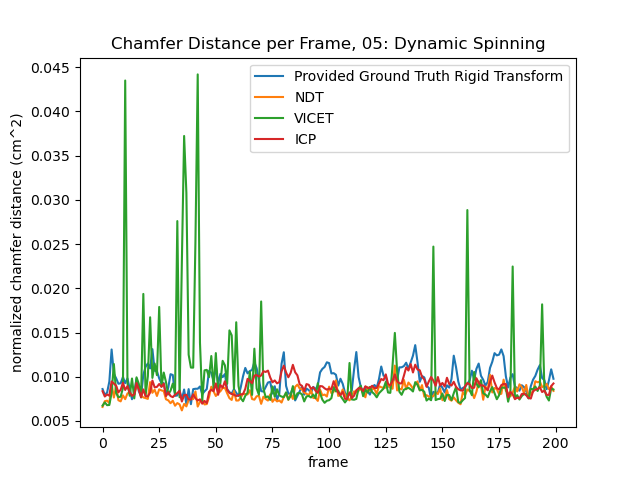

In [101]:
# # #Quad with dynamics
np.savetxt("results/raw_CD_05_2700_v1.txt", raw_CD_hist)
np.savetxt("results/ICET_CD_05_2700_v1.txt", rigid_ICET_CD_hist)
np.savetxt("results/ICP_CD_05_2700_v1.txt", ICP_CD_hist)
np.savetxt("results/VICET_CD_05_2700_v1.txt", VICET_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_05_2400_v1.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_05_2400_v1.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_05_2400_v1.txt")

# # # ##dynamic spinning
# # np.savetxt("results/raw_CD_06_950_v5txt", raw_CD_hist)
# # np.savetxt("results/ICET_CD_06_950_v5.txt", rigid_ICET_CD_hist)
# # np.savetxt("results/VICET_CD_06_950_v5.txt", VICET_CD_hist)
# # np.savetxt("results/ICP_CD_06_950_v5.txt", ICP_CD_hist)
# raw_CD_hist = np.loadtxt("results/raw_CD_06_950_v5.txt")
# rigid_ICET_CD_hist = np.loadtxt("results/ICET_CD_06_950_v5.txt")
# VICET_CD_hist = np.loadtxt("results/VICET_CD_06_950_v5.txt")
# ICP_CD_hist = np.loadtxt("results/ICP_CD_06_950_v5.txt")


#throw out frames where each are worse than provided ICP baseline (it happens but very rarely)
bad_idx = np.where(VICET_CD_hist > raw_CD_hist)
VICET_good_idx = np.where(VICET_CD_hist < raw_CD_hist)
# VICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
bad_idx = np.where(rigid_ICET_CD_hist > raw_CD_hist)
ICET_good_idx = np.where(rigid_ICET_CD_hist < raw_CD_hist)
# rigid_ICET_CD_hist[bad_idx] = raw_CD_hist[bad_idx]
ICP_good_idx = np.where(ICP_CD_hist < raw_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "NDT")
ax.plot(VICET_CD_hist, label = "VICET")
ax.plot(ICP_CD_hist, label = "ICP")
ax.set_title("Chamfer Distance per Frame, 05: Dynamic Spinning")
# ax.set_title("Chamfer Distance per Frame, 06: Dynamic Spinning")
ax.set_xlabel("frame")
ax.set_ylabel("normalized chamfer distance (cm^2)")
ax.legend(loc = 'best')

In [102]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist[:-10])) #, np.sqrt(np.mean(raw_CD_hist)))
print("\n NDT:", np.mean(rigid_ICET_CD_hist))#, np.sqrt(np.mean(rigid_ICET_CD_hist[40:])))
print("\n VICET:",np.mean(VICET_CD_hist))#, np.sqrt(np.mean(VICET_CD_hist[40:])))
print("\n ICP:", np.mean(ICP_CD_hist), "\n")

print("\n ICET (filtered):", np.mean(rigid_ICET_CD_hist[ICET_good_idx]))
print("\n VICET (filtered):",np.mean(VICET_CD_hist[VICET_good_idx]))
print("\n ICP (filtered):",np.mean(ICP_CD_hist[ICP_good_idx]))


 provided Ground Truth: 0.009534999164507577

 NDT: 0.008116907521616668

 VICET: 0.010005117112305015

 ICP: 0.008860884960740804 


 ICET (filtered): 0.008059863267200333

 VICET (filtered): 0.008095133902938806

 ICP (filtered): 0.008689318163748327


In [ ]:
# np.savetxt("results/raw_CD_05.txt", raw_CD_hist)
# np.savetxt("results/ICET_CD_05.txt", rigid_ICET_CD_hist)
# np.savetxt("results/VICET_CD_05.txt", VICET_CD_hist)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(raw_CD_hist, label = "Provided Ground Truth Rigid Transform")
ax.plot(rigid_ICET_CD_hist, label = "ICET")
ax.plot(VICET_CD_hist, label = "VICET")
ax.legend(loc = 'best')

print(err_hist)

In [ ]:
print("\n provided Ground Truth:", np.mean(raw_CD_hist))
print("\n ICET:", np.mean(rigid_ICET_CD_hist))
print("\n VICET:",np.mean(VICET_CD_hist))

In [ ]:
#debug is cloud wrapping around >>360deg???
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

y = dc.yaw_angs
yaw_angs_scaled = (y + 2*np.pi)%(2*np.pi)
# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
ax.plot(yaw_angs_scaled, label="new")

#get indices len(yaw_angs_scaled)//8 where yaw_angs_scaled is less than pi  
problem_idx = np.argwhere(yaw_angs_scaled[:len(yaw_angs_scaled)//8] < np.pi)
all_idx = np.linspace(0,len(yaw_angs_scaled)-1, len(yaw_angs_scaled))
good_idx = np.setdiff1d(all_idx, problem_idx).astype(np.int32)
ax.plot(yaw_angs_scaled[problem_idx])
ax.plot(good_idx, yaw_angs_scaled[good_idx])

# ax.plot(dc.yaw_angs, label = "raw (causing bug??)")
# ax.plot(ordered_yaw_angs, label = "raw (causing bug??)")
# ordered_yaw_angs = (dc.yaw_angs[np.argsort(dc.yaw_angs)] + np.pi) % (2*np.pi)
ax.set_title("yaw angles per beam, newer college dataset")
ax.legend(loc="best")

In [ ]:
#debug: try applying arbitrary motion profile scan to try and replicate discontinuity bug 
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


m_hat = np.array([10., 0., 0., 0., 0., 0.])

scan1_distorted = dc.apply_motion_profile(scan1_lidarframe, m_hat)


disp.append(Points(scan1_lidarframe, c = "red", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(scan1_distorted, c = "blue", r = 3, alpha = 0.2)) ##CB2314
disp.append(Points(submap_lidarframe, c = "black", r = 2, alpha = 0.05)) ##CB2314

plt.show(disp, "06 Dynamic Spinning Frame #" + str(idx))
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG: shuffling points in cloud 2 at the beginning produces bug, however, need to randomize 
#       which points are selected when fitting guassian

# print(dc.inside2.bounding_shape())
test = dc.fit_gaussian(dc.cloud2_tensor, dc.inside2, tf.cast(dc.npts2, tf.float32))
# print(test)
# print(tf.shape(dc.cloud2_tensor))
# print(dc.inside2[100])

#GOAL: shuffle ragged tensor <inside2>
digits = tf.ragged.constant([[1,2,3],[],[3,4],[4,5,6,7]])
print(digits)
a = tf.random.shuffle(tf.range(digits.shape[0]))
b = tf.reshape(a, (digits.shape[0], 1))
shuffledDigits = tf.gather_nd(digits, b)
print(shuffledDigits)

print(dc.inside2.bounding_shape())

## Run Rigid (6-State) ICET

In [ ]:
it = ICET(cloud1 = scan1_lidarframe, cloud2 = submap_lidarframe, fid = 50, niter = 25, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
print(it.cloud2_tensor.numpy())

In [ ]:
test = dc.cloud1_tensor_spherical
print(test)

# test2 = tf.gather(tf.)

smaller = tf.where(test[:,1] < 0.5)
print(smaller)
bigger = tf.where(test[:,1] > 0.4)
test2 = tf.sets.intersection(tf.transpose(smaller),tf.transpose(bigger))
print(test2.values)

print(tf.gather(test, test2.values))

# Draw provided "ground truth" trajectory on top of HD Map

In [ ]:
#transform LIDAR scan to align with HD Map -- not what we want
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  # draw HD Map in red

#draw trajectory of platform according to <gt>
# disp.append(Points(gt[2225:3200,2:5], r=3))#, alpha = 0.2))
# disp.append(Points(gt[2241:3000,2:5], r=3))#, alpha = 0.2))
disp.append(Points(gt[2020:3000,2:5], r=3))#, alpha = 0.2)) #full loop starting from static pose

disp.append(Points(gt[2400,2:5][None,:], r=15, c= 'blue'))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(50):
#     rot_m = R.from_quat(gt[i*20,5:]).as_matrix()
#     arrow_end = gt[i*20,2:5] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt[i*20,2:5], arrow_end, c='red'))

plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)


In [ ]:
#DEBUG
from matplotlib import pyplot as plt

euls = np.zeros([len(gt), 3])

for i in range(len(gt)):
    euls[i, :] = R.from_quat(gt[i,5:]).as_euler('xyz')

fig, ax = plt.subplots()
ax.plot(euls[:,2])

# ax.plot(gt[:,2:4])
# ax.plot(gt[:,0])

In [ ]:
# #transform HD Map to align with lidar frame
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
# disp=[]

# # rot_m = R.from_quat(gt[idx,5:]).as_matrix() #nope

# rot = R.from_quat(gt[:,5:]).as_euler('xyz')
# rot -= rot[0]
# rot[:,2] = -rot[:,2]
# # print(rot)
# rot_m = R.from_euler('xyz', rot[idx]).as_matrix()

# map_trans = (submap - gt[idx, 2:5]) @ rot_m
# disp.append(Points(pc1, c = 'blue', r = 3))
# # disp.append(Points(pc1[:(len(pc1)//2)], c = 'blue', r = 3))
# # disp.append(Points(pc1[(len(pc1)//2):], c = 'blue', r = 3, alpha = 0.2))

# #draw axis for world frame
# disp.append(Arrow([0,0,0], [2,0,0], c = 'red'))
# disp.append(Arrow([0,0,0], [0,2,0], c = 'green'))
# disp.append(Arrow([0,0,0], [0,0,2], c = 'blue'))
# #draw axis for world frame transformed by rot_m
# disp.append(Arrow([0,0,0], [2,0,0] @ rot_m, c = 'red', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,2,0] @ rot_m, c = 'green', alpha = 0.2))
# disp.append(Arrow([0,0,0], [0,0,2] @ rot_m, c = 'blue', alpha = 0.2))


# disp.append(Points(np.array([[0.,0.,0.]]), c = 'purple', r =10))

# disp.append(Points(map_trans, c = 'red', r = 2, alpha = 0.2))
# plt.show(disp, "HD Map")
# ViewInteractiveWidget(plt.window)

In [ ]:
# newscan_mapframe = np.append(pc1, np.zeros([len(pc1),1]), axis=1)
# newscan_mapframe = poses[1] @ newscan_mapframe.T
# print(newscan_mapframe.T)

In [ ]:
# print(rot)
# rot_m @ np.array([0.,0.,0.])

In [ ]:
# map_trans = (submap - gt[idx, 2:5]) @ rot_m

# it = ICET(cloud1 = pc1, cloud2 = map_trans, fid = 50, niter = 5, 
#            draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
# print("\n predicted standard deviations of error: \n", it.pred_stds)
# ViewInteractiveWidget(it.plt.window)